In [1]:
import numpy as np
from itertools import compress
import random
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 10)
from mpl_toolkits.mplot3d import Axes3D 
import tikzplotlib
from itertools import chain, combinations
import pickle
import sys
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
float_formatter = "{:.3e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
plt.rcParams.update({'font.size': 22})

In [2]:
!pip install matplotlib2tikz

In [33]:
def get_alives(x,a,b,basis,previous=None,thresh=1e-12,debug=False):
    if debug:
        print(f'Computing the list of elements that are alive with threshold {thresh}')
        print(f'x: {x}')
        print(f'a: {a}')
        print(f'b: {b}')
    x_=change_basis(x.copy(),orthonormal_basis(len(x)),basis)
    #print('get_alives')
    #print(x_)
    if sum((x_-a)>-thresh)<len(x_) or sum((b-x_)>-thresh)<len(x_):
        print('Issue: x is out of bound!')
    alive=(np.abs(x_-a)>thresh) & (np.abs(x_-b)>thresh)
    #print(alive)
    return alive,None if previous is None else [i for i in range(len(alive)) if ((previous[i]) and not alive[i])]

def choose_pivot(x,alive,mode='random',debug=False):
    if debug:
        print(f'Choosing pivot through mode {mode}.')
        print(f'x: {x}')
        print(f'Alive: {alive}')
    if mode=='max':
        for i in range(len(x),0,-1):
            if alive[i]:
                return i
        return -1
    if mode=='random':
        try:
            return random.choice(np.arange(len(x))[alive])
        except IndexError:
            #print('Every element is fixed')
            return -1
    
def next_direction(p,v,x,a,b,alive,debug=False):
    u=np.zeros(len(v))
    u[p]=1
    B=np.transpose(np.vstack(tuple([e for e in v])))#is v already a list ? If so we can simplify syntax here
    alive_and_not_pivot=alive.copy()
    #print(alive_and_not_pivot)
    #print(p)
    alive_and_not_pivot[p]=False
    if debug:
        print(f'Alive and not pivot: {alive_and_not_pivot}')
    alive_and_not_pivot=np.asarray(alive_and_not_pivot)
    B_t=B[:,alive_and_not_pivot]
    #print(f'B_t: {B_t}')
    #print(f'B_t^T*B_t: {np.matmul(np.transpose(B_t),B_t)}')
    #print(f'det: {np.linalg.det(np.matmul(np.transpose(B_t),B_t))}')
    u1=-np.matmul(np.matmul(inv(np.matmul(np.transpose(B_t),B_t)),np.transpose(B_t)),v[p])
    #print(f'u:{u}')
    #print(f'u1:{u1}')
    u[alive_and_not_pivot]=u1
    if debug:
        print(f'Calculated update direction u:{u}')
    return u

def next_direction2(p,v,x,a,b,alive,basis,debug=False):
    u=np.zeros(len(v))
    u[p]=1#u should have its proj on the pivot basis vector be 1
    #print(np.vstack(tuple([e for e in basis])))
    #print(np.transpose(np.vstack(tuple([e for e in v]))))
    B=np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis])).T)#is v already a list ? If so we can simplify syntax here
    #print(np.vstack(tuple([e for e in v])))
    #print(np.transpose(np.vstack(tuple([e for e in basis]))))
    #print(B)
    alive_and_not_pivot=alive.copy()
    #print(alive_and_not_pivot)
    #print(p)
    alive_and_not_pivot[p]=False
    if debug:
        print(f'Alive and not pivot: {alive_and_not_pivot}')
    alive_and_not_pivot=np.asarray(alive_and_not_pivot)
    B_t=B[:,alive_and_not_pivot]
    #print(f'B_t: {B_t}')
    #print(f'B_t^T*B_t: {np.matmul(np.transpose(B_t),B_t)}')
    #print(f'det: {np.linalg.det(np.matmul(np.transpose(B_t),B_t))}')
    u1=-np.matmul(np.matmul(inv(np.matmul(np.transpose(B_t),B_t)),np.transpose(B_t)),B[:,p])#np.matmul(B,basis[p]) instead of v[p]?
    #B_t2=B.copy()
    #B_t2[:,~alive_and_not_pivot]=0
    #mid=inv(np.matmul(np.transpose(B_t2),B_t2))
    #mid[~alive_and_not_pivot,:][:,~alive_and_not_pivot]=0
    #u2=-np.matmul(np.matmul(mid,np.transpose(B_t2)),v[p])#np.matmul(B,basis[p]) instead of v[p]?
    #print(f'u:{u}')
    #print(f'u1:{u1}')
    u[alive_and_not_pivot]=u1
    #u2[p]=1
    #u[~alive_and_not_pivot]=0
    #u2[np.abs(u2)<1e-14]=0
    #B_t3=B.copy()
    #v2_p=v[p]
    #for b in range(len(basis)):
    #    if not alive_and_not_pivot[b]:
    #        #print(basis[b])
    #        #print(B_t3)
    #        B_t3=np.vstack([B_t3,basis[b]])
    #        if p==b:
    #            v2_p=np.append(v2_p,1)
    #        else:
    #            v2_p=np.append(v2_p,0)
    #print(B)
    #print(B_t3)
    #print(v2_p)
    #B_t3=B_t3[:,alive_and_not_pivot]
    #u3=-np.matmul(np.matmul(inv(np.matmul(np.transpose(B_t3),B_t3)),np.transpose(B_t3)),v2_p)
    #print(np.abs(u3-u2)<1e-10)
    #u3[p]=1
    if alive_and_not_pivot.any():
        q,r=np.linalg.qr(B[:,alive_and_not_pivot])
        rs=np.array([(r[i,:]==np.zeros(r.shape[1])).all() for i in range(r.shape[0])])
        if len(rs)!=0:
            q=q[:,~rs]
            v_perp=B[:,p]-q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T).dot(B[:,p])
        else:
            v_perp=B[:,p]
    else:
        v_perp=B[:,p]
    y=v_perp-v[p]
    if debug :#or max(np.abs(v_perp-np.vstack(tuple([e for e in v])).T.dot(u)))>1e-12:
        print(f'v_perp:{v_perp}')
        print(f'v_perp-sum u_i*v_i:{v_perp-B.dot(u)}')
    basis_constraints=[]
    basis_transformation=inv(np.transpose(np.vstack(tuple([e for e in basis]))))
    factor=1e20
    for i in range(len(alive_and_not_pivot)):
        if not alive_and_not_pivot[i]:
            if i==p:
                y=np.append(y,factor)
            else:
                y=np.append(y,0)
            basis_constraints.append(factor*basis_transformation[i,:])
    A=np.vstack([np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis_constraints]))])
    #print(y)
    #print(A)
    #u=np.linalg.lstsq(A,y)[0]
    #print(u)
    #u[(~alive_and_not_pivot)&(np.abs(u)<1e-14)]=0
    if debug:
        print(f'v_perp:{v_perp}')
        print(f'v_perp-sum u_i*v_i:{v_perp-B.dot(u)}')
    if False and len(u3)>0 and max(np.abs(u3-u))>1e-10 and False:#and (basis == orthonormal_basis(len(x))).all():
        print('ALERT')
        print(u3)
        print(u)
        print(u3-u)
    #u[alive_and_not_pivot]=u3
    if False and max(np.abs(u-u2))>1e-9 and False:
        print(B_t2)
        print(alive)
        print(p)
        print(u)
        print(u2)
        print(np.abs(u-u2))
        print('Details')
        print(np.matmul(np.transpose(B_t2),B_t2)[alive_and_not_pivot,:][:,alive_and_not_pivot]-np.matmul(np.transpose(B_t),B_t))
        print(inv(np.matmul(np.transpose(B_t),B_t)))
        print(mid)
        print(mid[alive_and_not_pivot,:][:,alive_and_not_pivot]-inv(np.matmul(np.transpose(B_t),B_t)))
    if debug:
        print(f'Calculated update direction u:{u}')
    return change_basis(u,basis,orthonormal_basis(len(u)))

def next_factor(x,u_,a,b,basis,debug=False,smallest_delta=False):
    u=change_basis(u_,orthonormal_basis(len(x)),basis)
    #print(u)
    non_zero=np.abs(u)>1e-10
    #print('next factor')
    #print(non_zero)
    x_=change_basis(x,orthonormal_basis(len(x)),basis)[non_zero]
    #print(x)
    #print(x_)
    deltas=np.concatenate(((a[non_zero]-x_)/u[non_zero],(b[non_zero]-x_)/u[non_zero]),axis=0)
    if debug:
        print(f'All deltas considered:{deltas}')
    try:
        d_p=min(deltas[deltas>=0])
        if debug:
            print(f'delta_+:{d_p}')
    except:
        print(f'No delta>=0: {deltas}')#could set d_p=0 maybe
    try:
        d_m=max(deltas[deltas<=0])
        if debug:
            print(f'delta_-:{d_m}')
    except:
        print(f'No delta<=0: {deltas}')#could set d_m=0 maybe
    r=random.random()
    if r>d_p/(d_p-d_m) or (smallest_delta and d_p<abs(d_m)):
        if debug:
            print('delta=delta_+')
        return d_p,d_m
    if debug:
        print('delta=delta_-')
    return d_m,d_p

def change_basis(v,basis1,basis2):#from basis1 to basis2
    #print(v)
    #print(basis1)
    #print(basis2)
    return np.matmul(np.linalg.inv(np.transpose(np.array(basis2))),np.matmul(np.transpose(np.array(basis1)),v))

def orthonormal_basis(n):
    basis=[]
    for i in range(n):
        v_i=np.zeros(n)
        v_i[i]=1
        basis.append(v_i)
    return basis

def gram_schmidt_walk(v,x,a=None,b=None,plot=False,debug=False,smallest_delta=False,basis=None,order=False):
    if a is None:
        if debug:
            print('Initializing a with -1s')
        a=-np.ones(len(x))
    if b is None:
        if debug:
            print('Initializing b with 1s')
        b=np.ones(len(x))
    if basis is not None and len(basis)<len(x):
        print('Basis is lacking vectors to be full-dimensional: replacing it by a canonical orthonormal basis')#could complete it with Gram-Schmidt maybe
        basis=None
    if basis is not None and np.linalg.cond(np.array(basis)) > 1/sys.float_info.epsilon:
        print('Basis matrix is singular: replacing it by a canonical orthonormal basis')#could complete it with Gram-Schmidt maybe too
        basis=None
    if basis is None:
        basis=orthonormal_basis(len(v))
    if sum(a<b)<len(x):
        print('Issue with hyper parallelepipeds: a>b for some dimension')
    alive,_=get_alives(x,a,b,basis,debug=debug)
    p=choose_pivot(x,alive,debug=debug)
    i=1
    colored=[]
    while p!=-1:
        if debug:
            print(f'\n Iteration {i}')
        u=next_direction2(p,v,x,a,b,alive,basis,debug=debug)
        d1,d2=next_factor(x,u,a,b,basis,debug=debug,smallest_delta=smallest_delta)
        if plot:
            plot_situation_v2(v,p,x,u,[d1,d2],i)
        x+=d1*u
        if debug:
            print(f'Incurred discrepancy:{norm(np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),x))}')
        alive,newly_colored=get_alives(x,a,b,basis,alive,debug=debug)
        #print(colored)
        #print(newly_colored)
        colored.extend(newly_colored)
        if not alive[p]:
            p=choose_pivot(x,alive,debug=debug)
        i+=1
        if i-2>len(x):
            print('Issue, the algorithm took more steps than expected')
            #print(f'x:{x}')
            #print(f'u:{u}')
        if debug:
            print('in basis')
            print(f'x:{change_basis(x,orthonormal_basis(len(x)),basis)}')
            print(f'u:{change_basis(u,orthonormal_basis(len(x)),basis)}')
    if order:
        return x,colored#change_basis(x,basis,orthonormal_basis(len(x))),colored
    else:
        return x#change_basis(x,basis,orthonormal_basis(len(x)))

def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

def sample_from_sphere(n):
    thetas=np.random.uniform(0,2*np.pi,n)
    return [np.array([np.sin(t),np.cos(t)]) for t in thetas]

def sample_from_ball(n,d=2):
    p=[]
    for i in range(n):
        u = np.random.normal(0,1,d)  # an array of d normally distributed random variables
        norm=np.sum(u**2) **(0.5)
        r = random.random()**(1.0/d)
        p.append(r*u/norm)
    return p
    #r = np.random.uniform(0,1,n)**0.5
    #theta = np.random.uniform(0,2*np.pi,n)
    #x = r*np.cos(theta)
    #y = r*np.sin(theta)
    #return [np.array([x[i],y[i]]) for i in range(n)]
    
def sample_binary(n,d):
    return [np.random.binomial(size=d, n=1, p= 0.5) for i in range(n)]

def inv(m):
    a,_ = m.shape
    i = np.eye(a, a)
    sol=np.linalg.lstsq(m, i)
    #print(sol[3])
    return sol[0]

def latex_vector(x):
    return str(list(x)).replace('[','').replace(']','').replace(',','\\ \n')

def plot_situation(v,p,x,u,deltas,i):
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
    B=np.transpose(np.vstack(tuple([e for e in v])))
    plt.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current relaxation',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    plt.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'H',label='Potential updated relaxation')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.63,0.05, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    plt.legend(bbox_to_anchor=(1.8, 1))
    tikzplotlib.save(f"gswalk{i}2d.tex")
    plt.show()
    if x.shape[0]==3:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]])

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x,y = np.meshgrid(tmp,tmp)
        z = 0*x

        ax.plot_surface(z+1,x,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.savefig(f"gswalk{i}3d.png")
        plt.legend()
        tikzplotlib.save(f"gswalk{i}3d.tex")
        plt.show()
        
def plot_situation_v2(v,p,x,u,deltas,i):
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    fig.subplots_adjust(wspace=0.1, hspace=0)
    ax1 = fig.add_subplot(1, 2, 2)
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])<1],[v[e][1] for e in range(len(v)) if np.abs(x[e])<1],'o',label='Colorless vector')
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])==1],[v[e][1] for e in range(len(v)) if np.abs(x[e])==1],'o',label='Colored vector')
    ax1.plot(v[p][0],v[p][1],'*',label='Pivot vector',markersize=12)
    B=np.transpose(np.vstack(tuple([e for e in v])))
    ax1.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current balance',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    ax1.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'<',label='Potential update')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.45,0.04, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    #ax1.legend(bbox_to_anchor=(0,0),loc='lower center')

    #tikzplotlib.save(f"gswalk{i}2d.tex")
    #plt.show()
    if x.shape[0]==3:
        #fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x_,y = np.meshgrid(tmp,tmp)
        z = 0*x_

        ax.plot_surface(z+1,x_,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x_,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x_,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x_,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x_,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x_,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Potential update')
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        #ax.set_xlabel('X')
        #ax.set_ylabel('Y')
        #ax.set_zlabel('Z')
        ax.legend(bbox_to_anchor=(0.8, -0.07))
    ax1.legend(bbox_to_anchor=(1.1, -0.07),ncol=2)
    plt.savefig(f"gswalkboth{i}.pdf", bbox_inches='tight')
    tikzplotlib.save(f"gswalk{i}both.tex")
    plt.show()
    
def naive_walk(vs_):
    vs=vs_.copy()
    indices=list(range(len(vs)))
    random.shuffle(indices)
    x=np.zeros(len(vs))
    output=np.zeros(len(vs[0]))
    for i in indices:
        v=vs[i]
        if norm(output+v)<norm(output-v):
            x[i]=1
            output+=v
        else:
            x[i]=-1
            output-=v
    return x

def norm(v):
    return np.sqrt(sum(v**2))

def normalize(v):
    return v/norm(v)

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def best_coloring(v):
    indices_subset=powerset(range(len(v)))
    v_mat=np.transpose(np.array(v))
    best_assignment=[]
    best_disc=None
    for i_s in indices_subset:
        assignment=np.array([1 if i in i_s else -1 for i in range(len(v))])
        disc=norm(np.matmul(v_mat,assignment))
        if best_disc is None or disc<best_disc:
            best_disc=disc
            best_assignment=assignment
    return np.sqrt(best_disc),best_assignment

def open_dic_file(file_name):
    try:
        file = open(file_name, "rb")
        dic = pickle.load(file)
        file.close()
        return dic
    except FileNotFoundError:
        return {}

def save_dic_to_file(dic,file_name):
    file = open(file_name,'wb')
    pickle.dump(dic,file)
    file.close()

Initializing a with -1s
Initializing b with 1s
Computing the list of elements that are alive with threshold 1e-12
x: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
Alive: [ True  True  True  True  True  True  True  True  True  True]

 Iteration 1
Alive and not pivot: [ True  True False  True  True  True  True  True  True  True]
v_perp:[4.801e-03 8.111e-02 -3.931e-02 3.475e-02 -5.586e-02 9.532e-02 3.819e-02
 -5.866e-02 3.752e-02 -4.914e-02]
v_perp-sum u_i*v_i:[-7.494e-16 5.551e-17 -1.457e-15 3.608e-16 -1.936e-15 -1.027e-15
 -6.245e-16 -7.216e-16 -1.381e-15 -4.857e-16]
v_perp

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:289: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Choosing pivot through mode random.
x: [1.000e+00 1.000e+00 1.000e+00 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
Alive: [False False False False False False False False False False]
in basis
x:[1.000e+00 1.000e+00 1.000e+00 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
u:[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00]
Initializing a with -1s
Initializing b with 1s
Computing the list of elements that are alive with threshold 1e-12
x: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0

v_perp:[1.981e-01 7.743e-03 1.118e-01 1.513e-01 -1.085e-01 1.059e-01 -2.065e-02
 2.652e-02 1.170e-01 1.246e-01]
v_perp-sum u_i*v_i:[5.341e-01 -1.002e+00 -1.701e-01 -4.640e-01 4.057e-01 4.982e-01 2.068e-01
 -8.964e-01 2.897e-02 5.686e-02]
Calculated update direction u:[-2.066e-09 1.013e+00 6.291e-01 7.608e-01 -2.220e-16 5.551e-16 -2.765e-01
 1.388e-16 3.573e-01 1.000e+00]
All deltas considered:[4.840e+08 -9.870e-01 -1.590e+00 -1.314e+00 3.617e+00 -2.799e+00
 -1.000e+00 -4.840e+08 9.870e-01 1.590e+00 1.314e+00 -3.617e+00 2.799e+00
 1.000e+00]
delta_+:0.9869587954808853
delta_-:-0.9869587954808856
delta=delta_-
Incurred discrepancy:2.7145636951959258
Computing the list of elements that are alive with threshold 1e-12
x: [2.039e-09 -1.000e+00 -6.209e-01 -7.509e-01 1.000e+00 -1.000e+00 2.729e-01
 -1.000e+00 -3.527e-01 -9.870e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.00

v_perp:[1.619e-01 -3.960e-02 1.542e-01 8.846e-02 -6.733e-02 -8.370e-03 -5.809e-02
 2.990e-02 8.350e-02 1.583e-01]
v_perp-sum u_i*v_i:[-1.913e-01 -4.244e-01 1.574e-01 -3.614e-01 7.605e-03 1.049e-01 8.917e-02
 -2.720e-01 4.009e-01 1.951e-02]
Calculated update direction u:[-2.776e-17 -1.665e-16 -2.498e-16 1.735e-17 2.082e-17 -1.665e-16
 -1.735e-17 -4.857e-17 -4.163e-17 1.000e+00]
All deltas considered:[-1.000e+00 1.000e+00]
delta_+:1.0
delta_-:-1.0
delta=delta_-
Incurred discrepancy:0.8523429164991998
Computing the list of elements that are alive with threshold 1e-12
x: [2.776e-17 1.665e-16 2.498e-16 -1.735e-17 -2.082e-17 1.665e-16 1.735e-17
 4.857e-17 4.163e-17 -1.000e+00]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [2.776e-17 1.665e-16 2.498e-16 -1.735e-17 -2.082e-17 1.665e

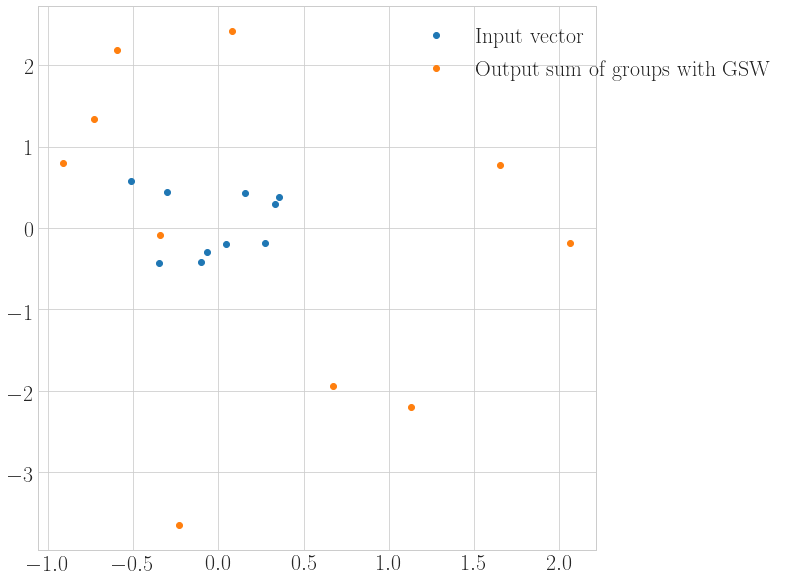

In [25]:
n=10
v=sample_from_sphere(n)
v=sample_from_ball(n,d=10)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    #print(i)
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=False,debug=True))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:289: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


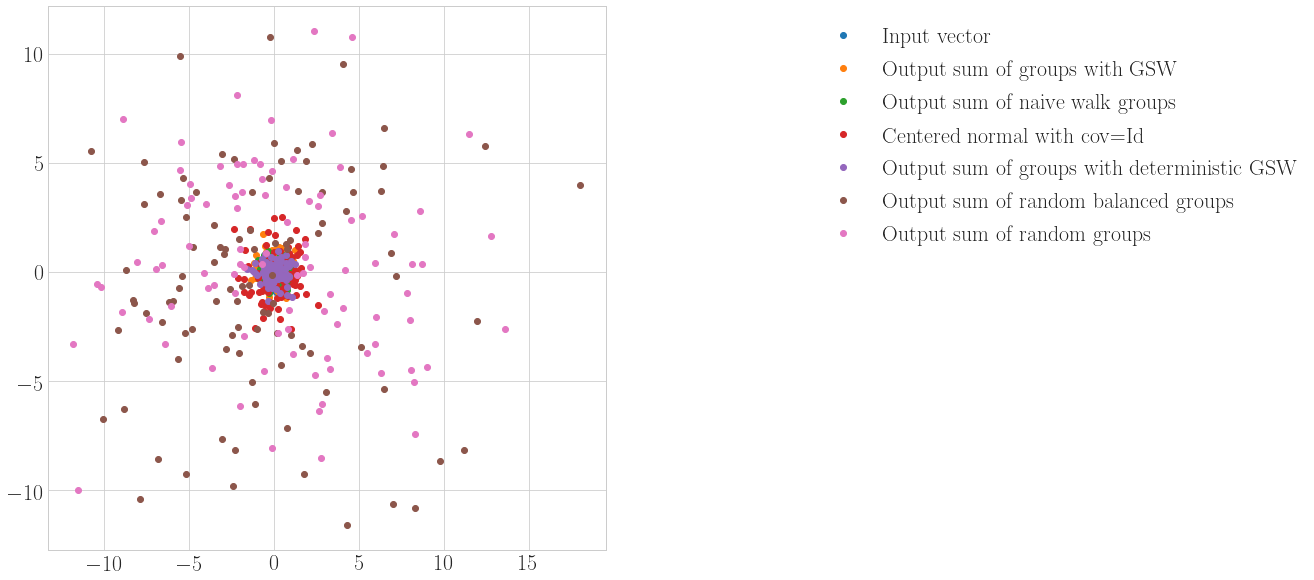

In [34]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
rand_xs=[]
balanced_xs=[]
subteam = [-1] * int(n/2) + [1] * int(n/2)
naive_xs=[]
deterministic_gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),debug=False))
    deterministic_gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),debug=False,smallest_delta=True))
    rand_xs.append(2*np.random.randint(2,size=n)-1)
    random.shuffle(subteam)
    balanced_xs.append(subteam.copy())
    naive_xs.append(naive_walk(v))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
normals=np.random.multivariate_normal(np.zeros(2), np.diag(np.ones(2)), size=n)
plt.plot([np.matmul(B,x)[0] for x in naive_xs],[np.matmul(B,x)[1] for x in naive_xs],'o',label='Output sum of naive walk groups')
plt.plot(normals[:,0],normals[:,1],'o',label='Centered normal with cov=Id')
plt.plot([np.matmul(B,x)[0] for x in deterministic_gsw_xs],[np.matmul(B,x)[1] for x in deterministic_gsw_xs],'o',label='Output sum of groups with deterministic GSW')

plt.plot([np.matmul(B,x)[0] for x in balanced_xs],[np.matmul(B,x)[1] for x in balanced_xs],'o',label='Output sum of random balanced groups')
plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


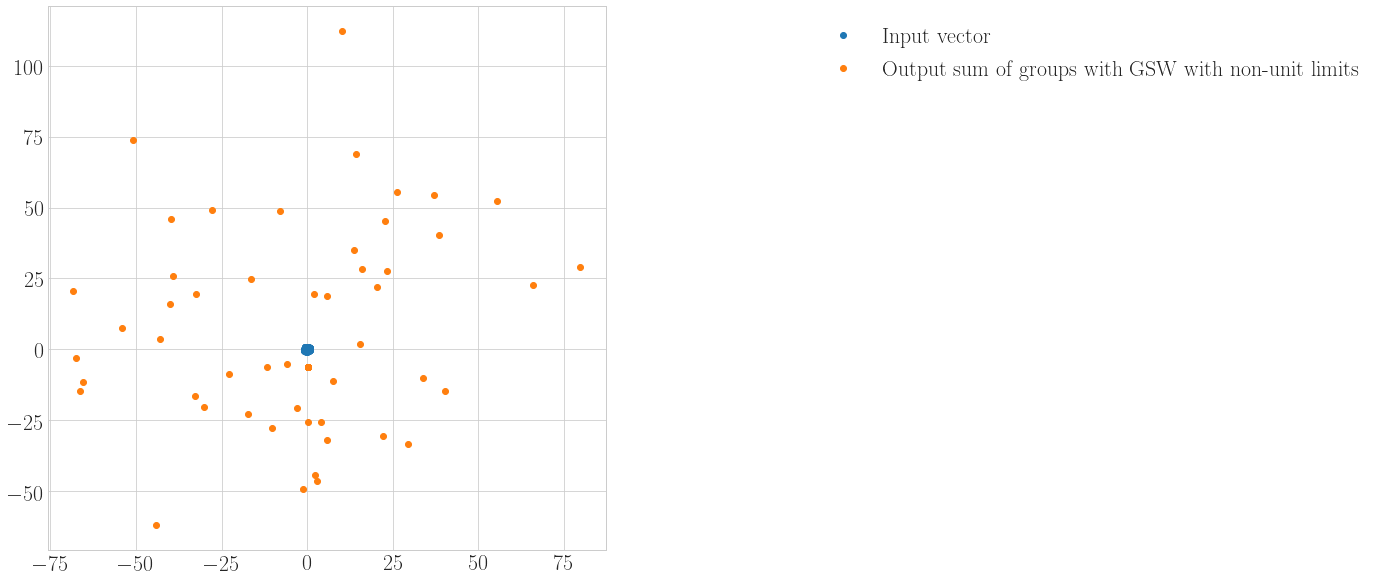

In [148]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),100*np.ones(n)
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW with non-unit limits')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


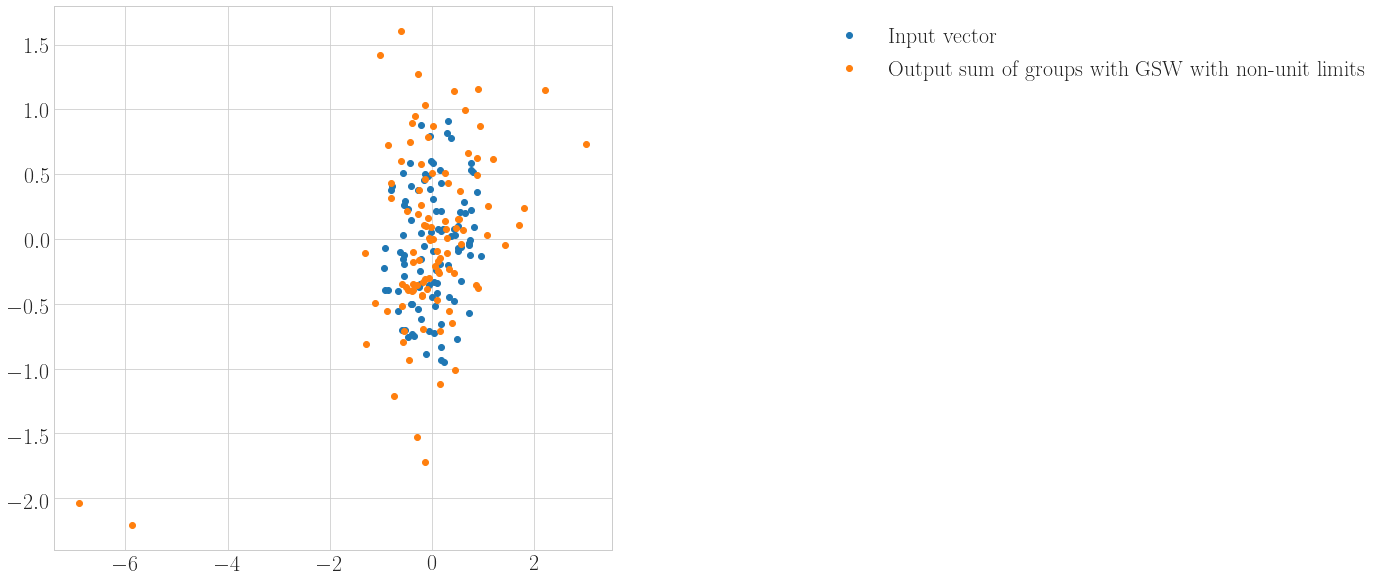

In [223]:
#Trying with a single big coordinate
n=100
v=sample_from_ball(n)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),np.ones(n)
a[1]=-15
#b[0]=20
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW with non-unit limits')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

Computing the list of elements that are alive with threshold 1e-12
x: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+0

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:289: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Choosing pivot through mode random.
x: [1.954e-01 -6.829e-01 1.352e+00 -9.505e-01 -5.560e-01 -3.615e-01 5.088e-01
 -1.381e+00 6.183e-01 8.876e-01 -1.719e+00 -1.083e+00 6.428e-01 1.117e+00
 -4.724e-02 -3.235e-01 -7.561e-02 5.222e-01 -2.191e-01 7.632e-01 8.291e-01
 9.295e-02 -8.280e-01 9.262e-01 -4.478e-02 -9.534e-02 5.828e-01 2.480e-01
 -2.911e-02 -6.972e-01]
Alive: [ True False  True  True False  True  True  True  True False  True False
  True False False  True  True False  True False  True False False  True
 False  True False False  True False]
in basis
x:[-1.800e-01 -1.000e+00 -8.628e-01 2.889e-01 -1.000e+00 -1.358e-01
 3.532e-01 7.016e-02 -1.620e-01 1.000e+00 1.424e-01 -1.000e+00 5.871e-02
 -1.000e+00 -1.000e+00 5.992e-01 6.308e-01 1.000e+00 -2.846e-01 -1.000e+00
 -1.755e-01 -1.000e+00 1.000e+00 -7.367e-01 -1.000e+00 -3.238e-01
 1.000e+00 -1.000e+00 6.170e-01 1.000e+00]
u:[-1.317e-01 1.943e-16 2.643e-01 2.156e-01 3.816e-17 2.314e-01 6.912e-02
 8.740e-03 -2.629e-01 -4.163e-17 3.502e

Incurred discrepancy:2.471503045804624
Computing the list of elements that are alive with threshold 1e-12
x: [1.303e-01 4.928e-01 1.540e+00 -2.912e-01 -7.976e-01 -5.804e-01 7.461e-01
 -1.246e+00 -2.338e-01 1.453e+00 -1.344e+00 -8.171e-01 5.501e-01 2.385e+00
 -8.823e-01 -1.202e+00 -2.750e-01 3.892e-01 -8.978e-02 4.283e-01 4.013e-01
 -4.243e-01 -1.534e+00 1.396e+00 -1.927e-01 -2.338e-01 6.729e-01 2.167e-02
 -1.980e-01 -2.128e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.

 4.454e-01 -2.290e+00 1.506e+00 -2.043e+00 -1.527e+00]
delta_+:0.2650173974868032
delta_-:-1.3199564428278532
delta=delta_+
Incurred discrepancy:0.17079316065198094
Computing the list of elements that are alive with threshold 1e-12
x: [-7.040e-01 7.207e-01 -5.582e-01 -3.362e-01 -6.673e-01 -4.048e-02
 -1.605e-01 6.427e-01 -9.500e-01 -1.082e-02 2.989e-01 -4.655e-01
 -1.189e+00 -4.307e-01 -1.468e-01 -2.587e-01 -7.982e-01 -2.444e-01
 4.819e-01 -5.062e-01 1.723e-01 -3.743e-01 -6.282e-02 -4.584e-01
 -4.488e-01 4.186e-01 -9.560e-02 -4.030e-01 6.759e-02 4.141e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.0

Choosing pivot through mode random.
x: [-8.710e-01 1.512e+00 -7.625e-01 4.406e-01 -1.287e+00 -1.401e-01 2.611e-01
 9.166e-01 -7.681e-01 -1.381e+00 4.706e-01 -3.403e-01 -1.560e+00
 -4.912e-01 1.458e-01 -5.839e-01 -5.179e-01 -4.208e-01 -3.219e-01
 -5.897e-01 4.736e-01 -3.592e-01 -6.905e-01 4.319e-01 7.758e-02 5.171e-01
 -4.851e-01 -2.850e-01 8.738e-01 1.179e+00]
Alive: [ True  True  True  True False False  True  True  True False  True False
 False  True  True  True  True  True False  True False  True False False
 False False False  True False False]
in basis
x:[-8.771e-01 5.930e-01 -1.639e-01 -1.416e-01 1.000e+00 1.000e+00 3.487e-01
 -2.593e-01 8.195e-01 1.000e+00 1.382e-02 1.000e+00 1.000e+00 8.917e-04
 7.489e-01 -6.356e-02 -4.503e-01 9.218e-02 1.000e+00 -4.038e-02 1.000e+00
 2.221e-01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 -1.000e+00 2.757e-01
 -1.000e+00 -1.000e+00]
u:[-1.490e-01 9.759e-02 -4.454e-01 -4.481e-02 -3.123e-17 4.163e-16
 -1.185e-02 1.798e-01 3.031e-01 -5.551e-17 -3.963e-0

Choosing pivot through mode random.
x: [-1.241e+00 9.417e-01 -1.751e+00 5.196e-02 -1.227e+00 5.867e-01 8.938e-01
 6.626e-01 -1.785e+00 -1.936e+00 8.725e-01 -2.401e-01 -1.227e+00 4.070e-02
 6.556e-01 -8.303e-01 2.520e-01 -2.599e-01 -1.683e-01 -1.643e-01 1.822e+00
 -9.923e-01 -5.318e-01 1.574e-01 4.160e-02 2.051e-01 1.318e-01 3.077e-01
 9.429e-01 1.307e+00]
Alive: [False False False False False False False  True  True False False False
 False False False False False  True False  True False  True False False
 False False False  True False False]
in basis
x:[-1.000e+00 1.000e+00 -1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 -8.335e-01 8.607e-01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 -1.000e+00 1.000e+00 -4.043e-01 1.000e+00 -7.961e-01 1.000e+00
 4.105e-01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 -1.000e+00 3.331e-01
 -1.000e+00 -1.000e+00]
u:[-2.914e-16 2.082e-17 1.000e+00 -2.082e-17 -1.041e-16 -2.220e-16
 -1.180e-16 2.131e-01 -1.601e-01 1.440e-16 -1.501e-16 1.04

delta_+:0.916911429444769
delta_-:-0.7882744881520818
delta=delta_-
Incurred discrepancy:0.508125633248855
Computing the list of elements that are alive with threshold 1e-12
x: [3.566e-01 6.390e-01 2.911e-03 3.718e-02 1.396e+00 -5.128e-01 9.335e-01
 1.555e-01 -6.799e-01 -6.443e-01 6.443e-01 2.933e-01 2.622e-02 1.130e+00
 1.949e-01 -1.605e-01 3.824e-01 8.001e-02 4.849e-01 3.624e-01 -1.321e-01
 -2.945e-01 -1.204e+00 9.440e-01 4.097e-01 3.517e-01 -5.615e-01 -1.768e-01
 9.089e-01 -4.721e-02]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.

v_perp:[-3.244e-02 -1.844e-01 -1.359e-02 1.922e-01 1.456e-01 5.338e-02 -2.449e-01
 -5.538e-02 1.051e-01 -1.069e-01 1.478e-01 1.645e-01 -1.293e-01 1.028e-01
 -8.038e-03 1.077e-01 6.723e-03 -2.793e-02 2.082e-01 9.082e-02 2.356e-01
 4.744e-02 3.707e-02 1.011e-01 -2.435e-01 7.669e-03 -2.891e-02 -2.860e-01
 -1.001e-01 -9.174e-02]
v_perp-sum u_i*v_i:[2.220e-16 -2.776e-16 5.135e-16 5.551e-17 -8.327e-17 7.078e-16 -1.665e-16
 -9.714e-17 -4.163e-17 6.106e-16 -3.608e-16 -5.551e-17 -2.776e-16
 4.441e-16 -3.313e-16 1.388e-17 -6.939e-17 -6.245e-16 0.000e+00 2.914e-16
 4.718e-16 1.804e-16 -4.025e-16 -3.192e-16 2.498e-16 -6.939e-17 -3.053e-16
 3.331e-16 1.110e-16 6.939e-17]
v_perp:[-3.244e-02 -1.844e-01 -1.359e-02 1.922e-01 1.456e-01 5.338e-02 -2.449e-01
 -5.538e-02 1.051e-01 -1.069e-01 1.478e-01 1.645e-01 -1.293e-01 1.028e-01
 -8.038e-03 1.077e-01 6.723e-03 -2.793e-02 2.082e-01 9.082e-02 2.356e-01
 4.744e-02 3.707e-02 1.011e-01 -2.435e-01 7.669e-03 -2.891e-02 -2.860e-01
 -1.001e-01 -9.174e-02]
v_perp

 1.458e-02 -7.953e-03 1.174e-02 2.816e-03]
v_perp-sum u_i*v_i:[4.406e-16 4.718e-16 4.163e-16 -7.702e-16 -5.898e-16 -4.927e-16 -4.259e-16
 -2.325e-16 4.718e-16 -4.163e-16 -3.816e-17 3.435e-16 -5.412e-16
 -6.939e-18 -4.823e-16 1.155e-15 4.025e-16 8.327e-17 -5.065e-16 -6.245e-16
 5.967e-16 -1.388e-17 4.302e-16 1.353e-16 4.894e-16 -1.353e-16 3.678e-16
 -1.422e-16 8.916e-16 1.185e-15]
Calculated update direction u:[-4.449e-03 -7.355e-02 2.351e-01 3.298e-01 0.000e+00 6.880e-01 3.669e-01
 1.517e-01 1.469e-01 -7.583e-01 -3.877e-01 4.460e-01 4.817e-01 -9.580e-02
 2.449e-01 2.192e-01 -4.127e-02 7.005e-01 1.000e+00 -2.392e-01 2.029e-01
 -2.872e-01 0.000e+00 1.073e+00 4.139e-01 8.038e-01 -4.661e-01 5.901e-02
 -3.643e-02 0.000e+00]
All deltas considered:[2.010e+02 1.976e+01 -4.555e+00 -4.972e+00 -1.197e+00 -3.002e+00
 -1.514e+00 -3.384e+00 1.590e+00 4.232e+00 -3.350e+00 -3.063e+00 4.378e+00
 -6.106e+00 -3.108e+00 2.183e+01 -7.234e-01 -1.478e+00 1.447e+00
 -4.227e+00 3.191e+00 -1.100e+00 -4.676e+00 

u:[1.648e-01 -1.664e-01 3.147e-01 5.973e-02 -1.388e-17 3.469e-17 -7.098e-02
 1.000e+00 -1.527e-16 9.714e-17 -1.804e-16 1.943e-16 -1.733e-01 3.921e-02
 -3.519e-01 -1.388e-16 1.543e-02 -8.327e-17 -1.943e-16 -1.388e-16
 -7.980e-17 -1.060e-01 -7.633e-17 -1.422e-16 -1.249e-16 -4.163e-17
 1.396e-16 5.551e-17 7.078e-02 -8.327e-17]

 Iteration 20
Alive and not pivot: [ True  True  True False False False  True False False False False False
  True  True  True False  True False False False False  True False False
 False False False False  True False]
v_perp:[-3.329e-01 -1.939e-01 -8.718e-03 -1.376e-01 -4.112e-02 -1.255e-01
 2.014e-02 -6.361e-02 -2.370e-02 2.138e-01 1.827e-01 8.536e-02 6.581e-03
 -9.005e-03 -8.118e-02 -1.199e-01 2.196e-01 -6.657e-02 -2.762e-02
 -3.942e-01 3.237e-02 -2.671e-02 2.155e-01 1.168e-01 -1.146e-01 7.070e-02
 4.866e-02 8.041e-02 -3.131e-02 -3.038e-01]
v_perp-sum u_i*v_i:[-2.776e-16 -5.551e-17 1.284e-16 -5.551e-17 1.388e-17 -1.110e-16 1.943e-16
 1.943e-16 1.388e-17 1.110e-1

 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [6.828e-01 -7.853e-01 4.587e-01 3.679e-01 5.872e-01 1.040e-01 1.307e-01
 -6.680e-01 1.019e+00 4.687e-02 -3.460e-01 4.394e-01 1.191e+00 3.675e-01
 1.072e-01 2.939e-01 7.501e-01 2.304e-01 -4.711e-01 4.884e-01 -2.253e-01
 4.081e-01 9.798e-02 3.769e-01 3.971e-01 -3.651e-01 1.392e-01 4.134e-01
 -1.234e-01 -4.194e-01]
Alive: [ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
in basis
x:[2.428e-01 1.978e-02 -1.707e-01 -2.363e-01 -3.932e-01 -1.000e+00
 -4.208e-01 -8.099e-02 -1.074e-01 5.950e-01 1.786e-01 -4.858e-01
 -7.450e-01 2.549e-02 -3.143e-01 -6.240e-03 2.500e-02 -5.071e-01
 -9.636e-01 1.855e-01 -1.758e-01 -1.263e-01 -4.064e-01 -8.849e-01
 -6.746e-01 -8.874e-01 8.135e-01 -4.325e-01 3.645e-01 3.983e-01]
u:[-2.428e-01 -1.978e-02 1.707e-01 2.363e-01 3.932e-01 1.000e+00 4.208e-01
 8.099e-02 1.074e-01 -

in basis
x:[1.194e-01 -3.174e-01 -1.000e+00 1.000e+00 -1.000e+00 -1.000e+00
 -2.658e-01 6.558e-02 -1.000e+00 -1.158e-01 -1.606e-01 -1.000e+00
 -1.000e+00 -5.103e-01 -6.779e-01 -4.006e-03 3.834e-01 -1.228e-01
 -1.000e+00 -4.759e-01 -2.442e-02 -8.337e-01 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00 1.000e+00 1.000e+00]
u:[-6.572e-02 6.518e-03 -1.631e-16 -6.939e-17 1.527e-16 -5.898e-17 3.531e-02
 -2.567e-01 1.388e-17 9.039e-02 3.609e-01 -3.816e-16 -1.960e-16 2.189e-01
 1.358e-01 -1.408e-01 -3.699e-01 -2.747e-01 1.665e-16 5.272e-02 -2.180e-01
 1.000e+00 1.926e-16 -1.180e-16 1.492e-16 2.220e-16 -1.431e-17 2.010e-01
 2.463e-16 1.110e-16]

 Iteration 17
Alive and not pivot: [ True  True False False False False  True  True False  True  True False
 False  True  True  True  True  True False  True  True False False False
 False False False False False False]
v_perp:[1.542e-03 -2.480e-02 2.397e-01 8.768e-02 9.281e-02 -2.113e-01 2.760e-01
 2.158e-01 -1.182e-01 1.183e-02 -1.074e

 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00 1.000e+00 1.000e+00]
u:[-3.331e-16 2.776e-17 -1.388e-16 1.249e-16 1.006e-16 -3.331e-16 -1.249e-16
 -9.714e-17 -2.082e-16 6.939e-17 6.862e-02 2.290e-16 4.163e-17 5.551e-17
 -1.527e-16 -1.110e-16 -1.388e-16 1.000e+00 -1.943e-16 1.249e-16
 -2.776e-17 -4.163e-17 0.000e+00 -5.551e-17 -8.327e-17 -4.163e-17
 6.245e-17 -1.249e-16 -1.440e-16 -4.857e-17]

 Iteration 30
Alive and not pivot: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
v_perp:[2.107e-01 -2.308e-01 2.211e-01 -2.208e-01 1.208e-01 1.725e-01 -7.277e-02
 -9.372e-02 2.089e-02 5.877e-02 -1.515e-01 6.515e-02 8.787e-03 8.867e-02
 -9.449e-02 -1.970e-01 -1.724e-01 -8.098e-02 -4.205e-02 -2.462e-01
 4.371e-01 1.231e-01 -2.932e-01 1.473e-02 2.120e-01 8.008e-02 -3.955e-01
 7.114e-02 6.883e-02 1.580e-01]
v_perp-sum u_i*v_i:[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.0

Choosing pivot through mode random.
x: [1.041e+00 -5.951e-01 5.373e-01 5.656e-01 1.205e+00 1.803e-01 5.752e-01
 -1.006e+00 1.781e+00 2.152e-01 -1.453e+00 2.991e-01 1.603e+00 1.403e+00
 -6.706e-02 2.121e-03 4.018e-01 7.400e-01 -4.056e-01 2.983e-01 -6.858e-01
 7.638e-01 -9.745e-01 3.039e-01 3.391e-01 -3.421e-01 -5.606e-01 1.869e-01
 -1.895e-02 -6.677e-01]
Alive: [ True False  True False False False False  True  True False  True  True
  True  True  True  True  True False False  True  True False  True False
 False False False  True  True False]
in basis
x:[7.229e-01 -1.000e+00 -6.138e-01 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 1.611e-01 8.793e-01 1.000e+00 -7.491e-03 -7.141e-01 -6.700e-01
 7.039e-02 -3.943e-01 7.614e-01 8.076e-02 -1.000e+00 -1.000e+00 5.135e-01
 -3.835e-01 -1.000e+00 -1.170e-01 -1.000e+00 -1.000e+00 -1.000e+00
 1.000e+00 -8.805e-01 5.645e-01 1.000e+00]
u:[-1.801e-01 1.000e+00 -2.613e-02 -2.498e-16 -1.874e-16 5.898e-16 0.000e+00
 -2.301e-01 -1.357e-01 -3.469e-16 -4.817

u:[1.000e+00 1.612e-01 3.879e-01 8.699e-02 -3.440e-01 -4.218e-01 -2.862e-01
 -1.100e-01 -9.232e-02 -4.195e-01 -4.308e-01 3.573e-01 -2.449e-01
 -2.239e-01 1.898e-01 1.600e-01 -3.469e-17 -7.981e-02 -6.196e-02 1.880e-02
 1.716e-02 -4.992e-01 -5.650e-01 5.388e-01 -1.527e-16 -6.011e-03 3.540e-01
 -1.508e-01 5.379e-01 6.420e-01]

 Iteration 4
Alive and not pivot: [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True False  True
 False  True  True  True  True  True]
v_perp:[3.659e-02 2.099e-02 2.841e-02 -6.267e-02 4.277e-02 1.720e-02 2.331e-02
 9.935e-02 -2.471e-01 3.122e-02 5.661e-02 1.645e-03 3.766e-02 4.098e-02
 7.641e-02 -1.295e-01 -1.416e-02 -3.133e-02 -1.465e-02 -5.634e-03
 -5.661e-02 3.472e-02 4.597e-02 4.892e-04 1.629e-02 1.665e-02 3.754e-02
 -9.060e-02 -1.237e-01 1.355e-01]
v_perp-sum u_i*v_i:[1.013e-15 7.355e-16 9.714e-16 -9.853e-16 -2.359e-16 -7.078e-16 -3.070e-15
 -1.624e-15 1.943e-16 7.702e-16 -2.637e

 -6.466e-01 1.000e+00 1.000e+00]
u:[3.053e-16 3.806e-01 -1.665e-16 -1.082e-01 2.347e-01 -1.249e-16 9.127e-03
 -7.591e-01 -4.166e-01 3.469e-18 2.220e-16 9.076e-02 1.041e-16 1.875e-02
 1.000e+00 -3.204e-01 5.274e-16 -2.966e-01 8.267e-02 -2.750e-01 -7.286e-17
 1.956e-01 6.939e-17 5.551e-17 3.747e-16 -3.354e-01 -2.078e-01 3.654e-01
 1.110e-16 2.220e-16]

 Iteration 15
Alive and not pivot: [False  True False  True  True False  True  True  True False False  True
 False  True False  True False  True  True  True False  True False False
 False  True False  True False False]
v_perp:[1.499e-01 1.910e-01 -3.875e-03 -7.753e-02 3.144e-02 -2.788e-02 -2.548e-02
 1.096e-02 9.105e-02 8.647e-02 1.688e-01 -1.106e-03 -1.478e-01 -1.556e-01
 2.090e-01 1.012e-01 1.556e-01 4.552e-03 -5.664e-02 6.701e-02 -2.415e-02
 -7.270e-02 -3.687e-01 -1.467e-01 1.189e-02 2.119e-01 6.287e-02 -5.775e-02
 -2.040e-01 -9.408e-02]
v_perp-sum u_i*v_i:[-1.110e-16 1.388e-16 -1.076e-16 4.996e-16 1.388e-16 -6.592e-17 -6.939e-17
 -3.29

 -4.590e-01 -1.346e-01 -3.637e-02]
v_perp-sum u_i*v_i:[-2.776e-17 2.776e-17 5.551e-17 0.000e+00 -8.327e-17 -6.939e-17 1.388e-17
 1.388e-17 -1.735e-17 9.714e-17 -1.388e-17 5.551e-17 0.000e+00 6.245e-17
 -2.776e-17 2.776e-17 -8.327e-17 0.000e+00 0.000e+00 8.327e-17 0.000e+00
 -2.082e-17 1.388e-17 -6.245e-17 -5.551e-17 2.776e-17 0.000e+00 5.551e-17
 0.000e+00 -6.939e-18]
v_perp:[-1.786e-01 -2.045e-01 -9.523e-02 3.090e-01 1.956e-01 4.874e-02 -1.978e-02
 3.604e-02 1.134e-03 3.379e-02 6.021e-02 -1.627e-02 -2.055e-01 -4.301e-02
 3.933e-02 1.025e-01 -1.388e-01 -4.028e-02 1.808e-01 1.174e-01 1.785e-01
 -2.908e-02 7.127e-02 -5.819e-02 -2.646e-01 6.985e-02 -1.603e-01
 -4.590e-01 -1.346e-01 -3.637e-02]
v_perp-sum u_i*v_i:[-2.776e-17 2.776e-17 5.551e-17 0.000e+00 -8.327e-17 -6.939e-17 1.388e-17
 1.388e-17 -1.735e-17 9.714e-17 -1.388e-17 5.551e-17 0.000e+00 6.245e-17
 -2.776e-17 2.776e-17 -8.327e-17 0.000e+00 0.000e+00 8.327e-17 0.000e+00
 -2.082e-17 1.388e-17 -6.245e-17 -5.551e-17 2.776e-17 0.000e+

 1.611e-01 -1.295e-01]
Alive: [ True False  True  True  True False  True  True  True  True  True  True
  True  True False  True False False  True  True  True False False False
 False  True  True  True  True False]
in basis
x:[-4.556e-03 1.000e+00 -7.038e-01 5.670e-02 3.005e-01 -1.000e+00 -7.086e-02
 -2.670e-01 3.092e-01 9.203e-01 7.151e-01 3.088e-01 3.090e-01 -5.750e-01
 -1.000e+00 -8.681e-02 1.000e+00 -1.000e+00 -7.413e-01 -3.894e-01
 -5.466e-01 -1.000e+00 -1.000e+00 -1.000e+00 1.000e+00 2.249e-01
 -5.831e-02 -3.753e-01 -2.732e-01 1.000e+00]
u:[-2.280e-01 1.000e+00 -1.285e-01 -3.078e-01 3.002e-01 7.910e-16 3.223e-01
 -3.795e-01 -3.184e-02 2.996e-01 1.889e-01 3.960e-01 1.653e-01 -1.267e-01
 2.880e-16 1.019e-02 2.637e-16 1.388e-16 -1.295e-01 -2.440e-01 1.893e-01
 -1.457e-16 9.021e-17 1.180e-16 3.192e-16 -3.454e-02 -1.974e-01 2.114e-01
 -2.785e-01 1.527e-16]

 Iteration 11
Alive and not pivot: [ True False  True  True False False  True  True  True  True  True  True
  True  True False  Tr

Choosing pivot through mode random.
x: [6.046e-01 -6.040e-01 -1.118e+00 1.361e+00 5.217e-01 1.174e+00 1.326e-01
 1.008e+00 1.252e+00 -6.179e-01 4.660e-01 2.010e+00 9.670e-02 1.370e+00
 3.484e-01 1.325e+00 2.398e-01 1.223e+00 -2.051e-01 1.274e+00 -8.118e-01
 -8.105e-01 -1.068e+00 1.836e+00 -6.233e-01 1.107e+00 9.990e-01 6.333e-01
 -2.968e-01 -7.008e-01]
Alive: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False]
in basis
x:[1.000e+00 1.000e+00 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00 -1.000e+00 1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 -3.522e-01 1.000e+00]
u:[-9.021e-17 1.388e-16 8.674e-18 1.000e+00 -1.214e-16 -4.545e-16 -1.041e-17
 -2.082e-17 5.204e-17 4.510e-17 9.714e-17 -1

Choosing pivot through mode random.
x: [-1.460e-01 5.298e-01 -8.352e-01 8.971e-02 -7.307e-01 3.680e-01 -3.028e-01
 8.808e-01 -1.823e+00 -8.705e-01 1.412e+00 -6.890e-02 -1.485e+00
 -1.266e+00 -1.803e-01 -1.871e-01 -4.426e-01 -4.035e-01 7.547e-02
 -7.937e-01 2.924e-01 -7.217e-01 3.857e-01 -6.894e-01 -1.211e-01 3.322e-01
 7.073e-02 4.064e-02 2.990e-01 1.142e+00]
Alive: [False  True  True  True False  True  True  True  True False  True False
  True  True False False  True  True False  True  True  True  True False
 False  True False  True  True False]
in basis
x:[-1.000e+00 6.182e-01 1.030e-01 3.689e-01 1.000e+00 8.610e-01 2.684e-01
 -3.662e-01 -2.813e-01 -1.000e+00 -2.035e-01 1.000e+00 7.575e-01 2.352e-01
 1.000e+00 -1.000e+00 -2.832e-01 -1.487e-01 1.000e+00 -5.126e-01 5.280e-01
 7.843e-01 -2.343e-01 1.000e+00 1.000e+00 6.803e-01 -1.000e+00 6.436e-01
 -9.128e-01 -1.000e+00]
u:[1.000e+00 -8.561e-02 4.433e-01 -1.123e-02 -2.012e-16 -1.552e-02
 -2.267e-01 -2.057e-02 -1.829e-01 2.429e-16 -1.740

 1.096e+00]
delta_+:1.0962052248672247
delta_-:-0.9037947751327754
delta=delta_-
Incurred discrepancy:2.585460870095195
Computing the list of elements that are alive with threshold 1e-12
x: [-6.673e-01 -9.975e-01 -4.714e-01 -3.236e-01 -4.659e-01 -1.883e-01
 -4.786e-01 9.498e-01 -1.234e+00 -1.214e+00 6.598e-01 -4.508e-01
 -2.937e+00 -1.804e+00 2.889e-01 -1.739e-01 -1.340e-01 2.617e-01
 -6.682e-01 -1.200e+00 1.023e+00 -8.099e-01 -1.256e-01 -1.507e+00
 -9.280e-03 1.921e-01 6.711e-01 -3.028e-01 8.803e-01 1.225e+00]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00

 1.272e+00 -2.836e+00 -1.437e+00]
delta_+:0.021669763857104726
delta_-:-1.3275862412500603
delta=delta_+
Incurred discrepancy:0.18304501032777123
Computing the list of elements that are alive with threshold 1e-12
x: [-5.856e-01 7.513e-01 -6.948e-01 -5.871e-02 -6.716e-01 1.922e-01
 -1.362e-01 1.045e+00 -1.056e+00 -3.482e-01 4.351e-01 -5.531e-01
 -1.236e+00 -3.953e-01 -1.435e-01 -3.310e-01 -6.430e-01 -6.490e-02
 4.691e-01 -3.644e-01 1.900e-01 -5.515e-01 -2.539e-01 -2.384e-01
 -2.283e-01 5.316e-01 5.162e-02 -3.320e-01 2.107e-01 5.250e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.00

Alive and not pivot: [False False False  True  True False  True  True False  True False False
 False  True False  True  True  True False  True  True False False False
 False False False False False False]
v_perp:[1.322e-01 -3.190e-01 2.941e-01 -1.280e-01 -1.554e-01 7.207e-02 -3.859e-02
 -1.294e-02 -5.203e-02 9.415e-02 1.217e-01 -1.031e-01 -1.166e-01
 -1.525e-01 -5.852e-02 2.844e-02 6.406e-03 4.089e-02 -4.797e-03 4.403e-01
 -6.040e-02 -6.160e-02 1.752e-01 -1.650e-01 -2.895e-01 2.607e-02 4.913e-02
 1.505e-02 -2.363e-02 -1.563e-01]
v_perp-sum u_i*v_i:[-5.551e-17 1.665e-16 -5.551e-17 -2.776e-16 -5.551e-17 -1.249e-16
 3.469e-17 1.943e-16 1.388e-16 -8.327e-17 -1.249e-16 1.110e-16 -5.551e-17
 8.327e-17 1.457e-16 8.674e-17 -2.776e-17 -1.388e-16 -1.180e-16 0.000e+00
 -1.180e-16 2.082e-17 8.327e-17 -5.551e-17 -5.551e-17 -1.180e-16 1.318e-16
 -1.665e-16 6.939e-17 -2.220e-16]
v_perp:[1.322e-01 -3.190e-01 2.941e-01 -1.280e-01 -1.554e-01 7.207e-02 -3.859e-02
 -1.294e-02 -5.203e-02 9.415e-02 1.217e-0

Alive and not pivot: [ True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True]
v_perp:[-1.863e-02 -3.660e-03 5.024e-02 -5.755e-02 2.319e-02 -2.038e-02 1.416e-01
 -1.124e-02 7.626e-02 9.405e-02 3.947e-02 -3.325e-02 -3.259e-02 7.064e-03
 -8.143e-03 -8.829e-02 -6.887e-03 -5.485e-02 1.248e-01 -1.348e-01
 8.230e-02 -1.006e-02 6.853e-02 -2.371e-03 4.430e-02 -6.589e-02 1.722e-01
 2.537e-02 -4.808e-02 -6.927e-02]
v_perp-sum u_i*v_i:[4.718e-16 -6.939e-17 -3.886e-16 7.494e-16 7.841e-16 1.180e-15 1.110e-16
 7.216e-16 -1.388e-16 1.360e-15 -5.274e-16 -2.776e-17 -1.416e-15
 -1.665e-15 -6.939e-16 -2.776e-17 -1.138e-15 -6.661e-16 -7.633e-16
 -3.053e-16 -6.384e-16 -6.384e-16 -9.021e-16 5.412e-16 1.443e-15
 -6.106e-16 3.053e-16 -7.494e-16 5.551e-17 7.216e-16]
v_perp:[-1.863e-02 -3.660e-03 5.024e-02 -5.755e-02 2.319e-02 -2.038e-02 1.416e-01
 -1.124e-02 7.626e-02 9.405e-02 3.947e-0

 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [-9.431e-01 -3.920e-01 -3.743e-01 -4.800e-01 -6.849e-01 -4.117e-02
 -1.019e+00 4.467e-01 -6.743e-02 1.555e+00 4.702e-01 -7.434e-01 3.752e-02
 -2.885e-01 2.271e-01 -6.229e-01 -1.935e+00 4.911e-01 5.286e-01 -8.185e-02
 -3.869e-01 -3.967e-01 1.195e+00 -1.061e+00 -1.830e+00 1.432e+00 9.638e-01
 9.131e-02 3.500e-02 -5.342e-01]
Alive: [ True  True False False False False  True False False False  True  True
 False False  True  True  True False False  True  True False False False
 False False  True  True  True False]
in basis
x:[7.299e-01 -2.982e-01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 2.463e-01
 1.000e+00 -1.000e+00 -1.000e+00 -6.584e-01 -2.298e-01 -1.000e+00
 -1.000e+00 8.993e-02 6.292e-02 5.941e-01 1.000e+00 1.000e+00 -8.610e-01
 -2.001e-01 -1.000e+00 -1.000e+00 1.000e+00 1.000e+00 1.000e+00 -6.936e-01
 2.476e-01 8.610e-01 1.000e+00]
u:[-1.851e-01 -9.133e-02 -1.735e-16 -2.359e-16 1.492e-16 -2.082e-17
 1.042e-01 -6.939e-18 -1.38

Alive and not pivot: [ True  True  True  True False False  True  True  True  True  True False
  True  True  True  True  True False False  True False  True  True False
  True  True False  True  True  True]
v_perp:[-1.205e-01 1.573e-02 1.522e-01 -6.403e-02 8.027e-02 1.052e-01 -5.429e-02
 -3.810e-02 1.622e-01 -1.280e-01 -1.801e-01 -4.144e-02 -5.399e-02
 -8.671e-02 3.212e-02 3.834e-02 1.499e-01 2.151e-01 5.565e-02 -4.977e-02
 9.722e-02 -2.681e-02 1.333e-01 4.747e-02 -1.810e-01 -5.911e-02 -2.286e-02
 -1.114e-01 -2.774e-03 1.196e-01]
v_perp-sum u_i*v_i:[-1.388e-16 7.633e-17 -5.274e-16 1.388e-16 -1.388e-16 4.163e-16 -2.220e-16
 6.106e-16 2.776e-17 -1.388e-16 2.776e-16 1.249e-16 0.000e+00 -6.661e-16
 -2.220e-16 -4.094e-16 -1.388e-16 -2.776e-16 2.776e-16 3.192e-16 1.027e-15
 4.302e-16 -3.886e-16 -3.608e-16 -4.718e-16 1.034e-15 5.551e-17 -7.216e-16
 -1.579e-16 -8.327e-17]
v_perp:[-1.205e-01 1.573e-02 1.522e-01 -6.403e-02 8.027e-02 1.052e-01 -5.429e-02
 -3.810e-02 1.622e-01 -1.280e-01 -1.801e-01 

 False  True False False  True False]
in basis
x:[2.308e-01 7.308e-01 9.365e-01 1.000e+00 1.000e+00 1.000e+00 -4.519e-01
 6.623e-02 -1.000e+00 -1.000e+00 -6.129e-02 1.000e+00 1.000e+00 -2.467e-01
 7.891e-01 -9.932e-01 -1.000e+00 -1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 -1.000e+00 1.000e+00 1.000e+00 4.463e-01 -1.000e+00 1.000e+00
 9.210e-03 -1.000e+00]
u:[8.223e-02 -2.154e-01 -1.281e-01 9.021e-17 1.214e-16 -3.053e-16 1.260e-01
 4.581e-02 -1.735e-16 6.245e-17 -2.996e-01 4.163e-17 0.000e+00 -6.356e-02
 6.674e-02 1.366e-01 -9.021e-17 -1.110e-16 -1.110e-16 -6.939e-17
 -1.318e-16 1.735e-16 1.000e+00 -7.546e-17 -9.021e-17 2.712e-01 -8.674e-18
 -5.551e-17 5.593e-02 -1.388e-17]

 Iteration 20
Alive and not pivot: [ True  True False False False False  True  True False False  True False
 False  True  True  True False False False False False False False False
 False  True False False  True False]
v_perp:[-1.721e-01 1.901e-01 3.602e-02 1.795e-01 -8.940e-02 1.373e-02 -9.509e-02
 1.113e-0

 -8.236e+00]
delta_+:0.49579825093407937
delta_-:-0.3460535595211474
delta=delta_-
Incurred discrepancy:0.3725310606327105
Computing the list of elements that are alive with threshold 1e-12
x: [-4.774e-01 -2.779e-01 -3.548e-01 -3.517e-01 -8.900e-01 3.206e-01
 -8.177e-01 5.127e-01 -1.798e-01 -2.977e-02 6.564e-01 3.219e-01 -6.181e-01
 -1.142e+00 5.477e-02 1.201e-01 -5.614e-01 -6.494e-02 1.252e-03 -3.855e-01
 -2.154e-02 -1.562e-02 1.441e+00 -1.134e+00 -1.428e-01 -1.284e-01
 4.617e-01 6.938e-02 -2.631e-01 1.795e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+0

Incurred discrepancy:1.5255048359301122
Computing the list of elements that are alive with threshold 1e-12
x: [-7.790e-01 3.478e-01 -4.954e-01 8.686e-02 -1.309e+00 1.505e-01 -1.564e+00
 1.535e+00 -2.007e-01 1.398e-02 3.955e-01 1.718e-02 -8.975e-02 -1.222e+00
 1.023e-01 -4.127e-01 -6.799e-01 -1.027e+00 -2.397e-01 -1.429e-01
 7.634e-02 -1.041e+00 1.058e+00 -8.911e-01 -1.042e+00 -2.526e-01 1.702e+00
 2.916e-01 -8.743e-01 6.384e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1

v_perp-sum u_i*v_i:[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 -6.939e-18 0.000e+00 0.000e+00 0.000e+00 1.388e-17 0.000e+00
 -6.939e-18 0.000e+00 -6.939e-18 0.000e+00 3.469e-18 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 -2.776e-17
 -5.204e-18 0.000e+00]
Calculated update direction u:[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 -5.087e-02 0.000e+00]
All deltas considered:[-1.218e+00 1.167e+01 7.815e-01 -2.765e+01]
delta_+:0.7815278128446943
delta_-:-1.2184721871553061
delta=delta_-
Incurred discrepancy:3.6956313227955473
Computing the list of elements that are alive with threshold 1e-12
x: [-1.181e+00 -5.856e-02 7.537e-01 1.783e-01 -2.159e+00 -4.710e-01
 -7.355e-01 1.919e+00 1

All deltas considered:[4.891e+00 2.752e+01 -4.465e+00 -7.479e+00 1.292e+01 -3.492e+00 -4.121e-01
 -7.742e-01 -5.990e+01 -5.345e+00 9.486e+00 4.966e+00 2.619e+00 -2.390e+00
 -3.423e+00 2.643e+00 -2.573e+00 -6.308e+01 1.237e+01 3.054e+01 -2.742e+00
 2.990e-01 1.588e+00 7.542e+00 4.828e+00 1.186e+01 -7.549e+00 -3.021e+00
 -3.056e+00 1.969e+00 1.253e+01 -3.053e+00]
delta_+:0.299028207376742
delta_-:-0.412076703212311
delta=delta_+
Incurred discrepancy:0.9379669496148645
Computing the list of elements that are alive with threshold 1e-12
x: [7.197e-01 1.138e-01 8.919e-01 1.107e-01 1.352e+00 -9.732e-01 1.075e+00
 -1.355e+00 8.463e-01 -5.736e-01 1.669e-02 1.020e+00 1.030e+00 1.192e+00
 4.326e-01 2.206e-01 1.052e+00 3.744e-02 -4.626e-01 -1.984e-02 -5.452e-01
 8.984e-01 -7.935e-01 5.039e-01 6.280e-01 -8.330e-01 -1.198e+00 -8.835e-02
 5.263e-01 -1.560e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.0

Alive and not pivot: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True]
v_perp:[2.018e-02 4.256e-02 5.217e-03 -2.552e-02 2.545e-02 1.666e-02 1.254e-02
 -4.052e-02 -5.466e-02 2.388e-02 -5.349e-02 3.445e-02 5.775e-03 -2.739e-02
 -9.375e-03 -1.340e-02 1.784e-02 1.506e-03 4.098e-02 -1.008e-03 1.380e-02
 -4.218e-02 5.731e-04 1.677e-02 -4.525e-02 -1.383e-02 1.919e-02 -2.059e-02
 2.613e-02 -6.106e-04]
v_perp-sum u_i*v_i:[3.490e-15 8.882e-16 5.690e-15 3.657e-15 3.768e-15 8.243e-15 -4.524e-15
 3.872e-15 3.317e-15 1.353e-16 3.969e-15 3.018e-15 1.318e-15 4.802e-15
 -8.396e-16 2.585e-15 8.882e-16 1.181e-15 2.845e-16 -9.576e-16 -5.135e-16
 -2.595e-15 1.707e-15 4.215e-15 -8.465e-16 -2.831e-15 -1.346e-15
 -3.261e-16 4.424e-15 1.311e-15]
v_perp:[2.018e-02 4.256e-02 5.217e-03 -2.552e-02 2.545e-02 1.666e-02 1.254e-02
 -4.052e-02 -5.466e-02 2.388e-02 -5.349e-02 3.445e-02 5.

 -1.728e-03 9.619e-02 1.778e-01 1.756e-01]
v_perp-sum u_i*v_i:[-1.388e-16 -2.290e-16 -3.469e-16 -1.943e-16 3.053e-16 -1.804e-16
 5.551e-17 -6.245e-17 -2.637e-16 -8.327e-17 2.220e-16 6.765e-17 -4.406e-16
 -1.665e-16 -1.665e-16 -5.829e-16 -1.665e-16 5.239e-16 -5.621e-16
 -5.135e-16 1.665e-16 -2.706e-16 1.249e-16 3.469e-17 9.714e-17 -1.804e-16
 -2.082e-16 -1.527e-16 -4.163e-16 4.996e-16]
Calculated update direction u:[1.541e-01 -2.115e-01 -1.893e-01 3.273e-02 0.000e+00 1.963e-01 1.531e-01
 0.000e+00 2.405e-01 -3.868e-01 -6.954e-02 1.305e-01 3.994e-01 6.917e-02
 0.000e+00 -8.887e-03 6.385e-01 0.000e+00 3.120e-01 -1.556e-01 -1.526e-01
 -4.939e-01 0.000e+00 0.000e+00 1.000e+00 0.000e+00 -2.934e-01 -2.627e-03
 -3.415e-01 -1.191e-01]
All deltas considered:[-8.025e+00 1.724e+00 5.907e+00 -2.995e+01 -7.837e+00 -6.442e+00
 -7.728e+00 1.277e+00 1.060e+00 -8.926e+00 -3.282e+00 -1.458e+01 1.840e+02
 -1.960e+00 -4.167e+00 1.041e+01 7.078e+00 9.882e-01 -6.314e-01 4.097e+00
 2.677e+02 3.793e+00 4.827e+

Choosing pivot through mode random.
x: [-5.228e-01 1.045e+00 -9.150e-01 -9.147e-01 -5.379e-01 -1.456e+00
 9.451e-01 -6.939e-01 -1.020e+00 1.262e+00 -1.447e-01 4.374e-01 -1.245e+00
 1.045e+00 -1.727e+00 -2.257e-01 -1.400e-01 -7.063e-01 6.460e-01
 -5.017e-02 9.435e-02 4.050e-01 -5.784e-01 2.349e-01 -7.855e-01 1.954e-01
 -4.654e-01 -1.986e+00 -4.296e-01 4.623e-02]
Alive: [ True False  True False False False False False False False False  True
 False  True False False False False False  True False  True False False
 False False  True  True  True  True]
in basis
x:[-1.869e-02 1.000e+00 5.431e-02 -1.000e+00 -1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 -1.000e+00 -1.000e+00 4.674e-01 1.000e+00 3.152e-01
 -1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.087e-01 -1.000e+00
 -6.570e-01 1.000e+00 1.000e+00 -1.000e+00 1.000e+00 5.166e-02 1.520e-02
 -3.598e-01 -9.760e-01]
u:[-5.908e-02 1.000e+00 8.923e-02 -3.123e-16 -1.735e-16 3.400e-16 -5.551e-17
 -2.914e-16 1.943e-16 -2.741e-16 -1.180e

All deltas considered:[-7.350e-01 1.265e+00]
delta_+:1.2650498415629159
delta_-:-0.7349501584370843
delta=delta_-
Incurred discrepancy:3.2625183726957574
Computing the list of elements that are alive with threshold 1e-12
x: [-1.105e-01 4.365e-01 -4.814e-01 -5.506e-01 -7.361e-01 -1.051e+00
 6.443e-01 9.604e-02 -1.352e+00 1.090e+00 -2.498e-02 1.411e-01 -2.002e+00
 1.588e+00 -1.643e+00 -6.662e-02 -2.461e-01 -1.117e+00 3.324e-02
 -7.050e-02 5.726e-02 -7.187e-01 -7.065e-01 1.022e+00 -8.873e-01 9.743e-01
 -1.328e+00 -2.730e+00 -6.320e-01 4.399e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+

Alive and not pivot: [ True  True  True False False False  True  True  True False  True  True
  True False  True False  True False  True  True  True  True False  True
 False  True  True False  True False]
v_perp:[-1.345e-01 5.873e-02 1.980e-01 9.225e-02 1.774e-01 -1.572e-01 -1.846e-01
 -2.534e-02 -8.239e-02 -1.150e-01 1.001e-01 1.190e-01 1.291e-01 2.348e-02
 -2.112e-01 6.229e-03 -1.791e-01 9.673e-02 1.102e-01 7.313e-02 8.338e-02
 1.707e-01 -1.907e-01 -2.261e-01 -1.448e-02 1.593e-01 2.938e-01 5.611e-02
 1.525e-01 -1.019e-01]
v_perp-sum u_i*v_i:[-2.776e-17 -4.163e-17 -2.776e-16 -1.388e-17 1.388e-16 -2.498e-16
 -1.943e-16 -2.325e-16 8.327e-17 1.388e-17 -2.776e-16 -3.053e-16
 -1.110e-16 -1.145e-16 -1.943e-16 3.790e-16 -1.665e-16 -4.163e-17
 0.000e+00 0.000e+00 1.110e-16 2.776e-17 1.388e-16 -1.665e-16 -6.592e-17
 -1.665e-16 1.110e-16 7.286e-16 -5.551e-17 2.220e-16]
v_perp:[-1.345e-01 5.873e-02 1.980e-01 9.225e-02 1.774e-01 -1.572e-01 -1.846e-01
 -2.534e-02 -8.239e-02 -1.150e-01 1.001e-01 1.

v_perp-sum u_i*v_i:[-5.551e-17 8.327e-17 -6.939e-17 2.776e-17 2.776e-17 8.327e-17 -2.776e-17
 -9.714e-17 -6.939e-18 5.551e-17 -3.686e-18 -8.327e-17 1.804e-16
 -5.551e-17 5.551e-17 8.327e-17 1.388e-17 8.327e-17 1.388e-17 3.469e-17
 -1.197e-16 5.551e-17 1.041e-16 0.000e+00 0.000e+00 -1.388e-17 4.163e-17
 5.551e-17 -2.776e-17 -8.327e-17]
Calculated update direction u:[0.000e+00 0.000e+00 -1.469e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 2.605e-01 0.000e+00 -9.118e-02 0.000e+00 5.645e-02 0.000e+00
 0.000e+00 0.000e+00 5.500e-02 0.000e+00 0.000e+00 0.000e+00 -2.095e-01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 -7.595e-02 0.000e+00
 -1.551e-02 0.000e+00]
All deltas considered:[9.798e+00 -4.398e+00 9.262e+00 -2.339e+01 -2.036e+01 7.787e+00 -1.487e+00
 2.047e+01 8.157e+01 -3.819e+00 3.280e+00 -1.267e+01 1.204e+01 1.601e+01
 -1.760e+00 5.130e-01 -5.862e+00 -4.739e+01]
delta_+:0.5129886853837315
delta_-:-1.4870113146162685
delta=delta_+
Incurred discrepancy:2.112435655073498

 -5.319e-01 5.287e-01 -8.191e-02 6.776e-01 5.304e-01]

 Iteration 3
Alive and not pivot: [False  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True]
v_perp:[3.623e-02 -2.165e-02 7.588e-03 -5.356e-02 8.980e-02 2.582e-02 -1.773e-02
 1.161e-01 -1.607e-01 5.973e-02 1.005e-01 -1.509e-02 1.913e-02 4.849e-02
 1.103e-01 -1.336e-01 -6.862e-02 -5.622e-02 8.206e-04 -3.420e-02
 -4.979e-02 1.439e-02 9.427e-02 -3.568e-02 2.894e-02 3.356e-02 7.851e-02
 -3.131e-02 -1.336e-01 1.321e-01]
v_perp-sum u_i*v_i:[9.298e-16 -8.153e-16 -2.918e-15 -1.527e-15 1.776e-15 -2.234e-15 2.186e-15
 -5.551e-17 5.551e-17 1.207e-15 1.360e-15 1.679e-15 -1.197e-15 -1.388e-15
 -1.110e-15 5.551e-17 -4.718e-16 -8.743e-16 -5.204e-16 -3.469e-16
 7.355e-16 5.690e-16 -1.277e-15 1.124e-15 1.527e-16 7.772e-16 -3.608e-16
 -1.665e-16 7.772e-16 6.106e-16]
v_perp:[3.623e-02 -2.165e-02 7.588e-03 -5.356e-02 8.980e-02 2

 8.089e+00 1.672e+01 3.759e+01 6.478e+00 1.278e+00]
delta_+:1.2775628415876186
delta_-:-0.30456322929877344
delta=delta_-
Incurred discrepancy:1.4311978574088673
Computing the list of elements that are alive with threshold 1e-12
x: [4.543e-01 3.003e-01 1.585e-01 1.242e+00 -8.619e-01 9.268e-01 -3.066e-01
 1.147e+00 -8.585e-01 -8.414e-01 1.549e-01 -1.629e+00 9.113e-01 1.831e-03
 -8.094e-03 -1.302e+00 -1.580e-02 8.557e-01 2.952e-01 3.044e-03 1.504e+00
 -4.118e-01 -6.055e-01 1.332e-01 1.262e-01 5.506e-01 1.002e+00 6.968e-01
 -2.830e-01 9.677e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+

Choosing pivot through mode random.
x: [2.881e-01 2.901e-01 -6.987e-01 1.242e+00 -6.217e-01 1.229e+00 -2.124e-01
 1.067e+00 -8.115e-01 -6.170e-01 6.720e-01 -1.246e+00 1.153e+00 1.039e+00
 -2.905e-01 -1.628e+00 3.271e-01 1.008e+00 4.529e-01 1.745e-01 1.862e+00
 -4.575e-01 -1.536e+00 3.996e-01 -3.166e-02 1.060e+00 1.296e+00 3.631e-01
 9.987e-02 9.058e-01]
Alive: [False  True False  True False  True False False False False False False
 False  True False  True False False False False  True False False False
 False False False False False False]
in basis
x:[-1.000e+00 4.107e-01 -1.000e+00 5.889e-01 1.000e+00 1.078e-01 1.000e+00
 -1.000e+00 1.000e+00 1.000e+00 1.000e+00 -1.000e+00 1.000e+00 -1.653e-01
 1.000e+00 -1.151e-01 1.000e+00 -1.000e+00 1.000e+00 -1.000e+00 -4.672e-01
 -1.000e+00 -1.000e+00 -1.000e+00 1.000e+00 1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 1.000e+00]
u:[-1.457e-16 -1.058e-01 -6.939e-18 9.900e-02 2.654e-16 2.516e-01 -3.469e-17
 -6.939e-17 -9.714e-17 1.093e-16 1.926e-16 -

 1.090e+00 -4.119e-01 1.881e+00 -6.776e-01]
delta_+:0.7490232495778506
delta_-:-0.40543928078705155
delta=delta_-
Incurred discrepancy:0.23126312510763516
Computing the list of elements that are alive with threshold 1e-12
x: [3.340e-01 -6.612e-01 7.217e-01 -6.271e-02 3.073e-01 5.600e-02 1.314e-01
 -1.080e+00 1.220e+00 9.203e-01 -1.099e+00 -1.316e-01 1.313e+00 6.009e-01
 4.626e-02 2.457e-01 3.876e-01 8.488e-02 -2.474e-01 4.305e-01 -1.473e-01
 5.565e-01 -1.152e-01 1.962e-01 -1.512e-01 -2.622e-01 2.101e-01 2.229e-01
 -5.492e-01 -6.417e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.0

b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00]
in basis
x:[5.893e-01 -2.912e-01 -2.517e-01 1.362e-01 -1.000e+00 -1.000e+00
 -5.714e-01 4.649e-01 2.026e-01 5.568e-01 5.725e-02 -1.000e+00 -1.000e+00
 -1.074e-01 -1.000e+00 4.007e-01 5.373e-01 -7.994e-01 -1.000e+00 8.869e-02
 -1.000e+00 -1.000e+00 -9.683e-01 -1.000e+00 -1.000e+00 -6.774e-01
 1.000e+00 -1.000e+00 1.000e+00 1.000e+00]
u:[-2.869e-01 -3.675e-01 1.345e-01 -1.137e-01 7.286e-17 -5.412e-16 2.172e-01
 -6.824e-02 -1.160e-01 2.653e-01 1.270e-01 3.973e-16 8.590e-02 -1.672e-01
 -1.856e-16 6.912e-02 -1.054e-02 1.000e+00 -2.637e-16 1.716e-01 -4.163e-17
 6.072e-17 6.246e-01 -9.021e-17 -1.804e-16 1.493e-01 5.204e-18 -1.006e-16
 -1.457e-16 1.041e-17]

 Iteration 15
Alive and not pivo

All deltas considered:[-6.928e-01 -1.042e+01 4.620e+02 2.546e+00 -1.224e+01 2.984e+00 6.897e+00
 1.307e+00 1.243e+01 -1.431e+01 -1.786e+00 5.576e+00 -3.054e+00 -1.593e-01]
delta_+:1.3071724167402459
delta_-:-0.159276987252624
delta=delta_-
Incurred discrepancy:2.208391772078769
Computing the list of elements that are alive with threshold 1e-12
x: [4.250e-01 -3.158e-01 2.459e-01 1.174e+00 7.240e-01 -4.731e-01 9.179e-02
 -4.290e-02 2.336e+00 1.646e+00 -8.010e-01 2.851e-01 2.151e+00 9.531e-01
 -2.998e-01 6.047e-01 1.422e+00 3.275e-01 -4.767e-01 8.842e-01 -9.690e-01
 1.748e+00 4.426e-01 2.267e-01 6.305e-02 -5.272e-01 2.779e-01 -3.330e-01
 -1.169e-01 -2.870e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e

 -2.383e-01 -7.783e-02]
v_perp-sum u_i*v_i:[6.939e-17 5.274e-16 2.429e-17 -8.604e-16 8.327e-17 -3.053e-16 4.163e-16
 -5.274e-16 -3.435e-16 -3.747e-16 8.327e-17 -4.892e-16 -4.302e-16
 6.939e-17 -2.498e-16 3.331e-16 5.551e-16 -1.180e-16 9.714e-17 0.000e+00
 -5.551e-16 3.608e-16 -2.220e-16 5.551e-17 -3.886e-16 5.551e-17 7.355e-16
 -2.776e-17 1.943e-16 -3.192e-16]
Calculated update direction u:[4.078e-01 6.107e-01 0.000e+00 -4.788e-01 2.232e-02 -3.948e-01 -2.493e-01
 -6.459e-01 0.000e+00 0.000e+00 -1.760e-01 3.303e-01 -3.293e-01 2.118e-01
 1.000e+00 -2.169e-01 0.000e+00 -6.575e-01 -2.778e-01 -8.120e-02 1.536e-01
 0.000e+00 -2.571e-01 0.000e+00 0.000e+00 -5.898e-01 1.402e-01 1.683e-01
 -1.576e-01 -7.030e-02]
All deltas considered:[-2.585e+00 -2.208e+00 2.974e+00 -6.999e+01 3.662e+00 4.746e+00 1.457e+00
 3.707e+00 -3.863e+00 1.849e+00 -4.806e+00 -1.103e+00 4.006e+00 2.384e+00
 5.106e+00 9.562e+00 -1.094e+01 1.733e+00 1.269e+00 -7.046e+00 -8.414e+00
 1.071e+01 1.174e+01 2.319e+00 1.066e+00 -1

All deltas considered:[-2.994e-01 1.523e+01 2.190e+00 5.180e+00 -6.814e+01 1.115e+01 4.296e+01
 1.701e+00 -6.057e+00 -6.825e+00 -1.343e+01 3.489e+01 -6.940e+00
 -3.086e+01]
delta_+:1.7006051372536193
delta_-:-0.2993948627463816
delta=delta_-
Incurred discrepancy:2.2946842067512065
Computing the list of elements that are alive with threshold 1e-12
x: [-1.619e+00 -5.840e-01 1.144e+00 -1.366e+00 -3.643e-01 -1.082e+00
 -8.848e-01 5.686e-01 2.925e-01 -1.022e-01 -3.517e-01 2.796e-01 -4.677e-01
 -9.556e-01 2.035e-01 -3.258e-02 -1.258e+00 -1.132e+00 4.663e-01
 -1.097e+00 1.420e+00 9.459e-01 1.050e+00 -1.722e+00 1.134e-01 -1.296e+00
 -1.156e+00 4.753e-01 -4.854e-01 -8.270e-02]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e

 -2.152e-01 -3.298e-02]
v_perp-sum u_i*v_i:[7.216e-16 4.163e-16 -5.100e-16 1.943e-16 -2.776e-17 2.914e-16 -1.180e-16
 -5.551e-17 -1.249e-16 1.110e-16 4.025e-16 1.388e-17 -4.302e-16 8.188e-16
 -9.159e-16 -3.886e-16 -5.274e-16 -2.776e-16 -2.776e-16 5.551e-17
 5.204e-16 -1.527e-16 5.551e-17 -1.388e-16 1.527e-16 -4.163e-17 -1.110e-16
 -4.025e-16 -2.776e-17 -4.025e-16]
Calculated update direction u:[0.000e+00 2.924e-01 0.000e+00 -1.779e-01 0.000e+00 -1.003e-01 7.053e-02
 -6.428e-01 -2.683e-01 1.231e-01 0.000e+00 6.182e-02 -1.248e-01 -4.172e-02
 1.000e+00 -3.454e-02 -3.167e-01 0.000e+00 1.382e-01 -2.477e-01 9.357e-02
 -5.599e-02 -6.974e-02 0.000e+00 0.000e+00 -2.495e-01 -1.087e-01 1.441e-01
 0.000e+00 3.509e-01]
All deltas considered:[-3.125e+00 5.230e+00 9.792e+00 -1.310e+01 1.439e+00 2.275e+00 -1.702e+00
 -1.586e+01 1.813e+00 2.488e+01 -1.734e+00 3.863e+01 1.998e+00 -8.748e+00
 4.485e+00 -1.306e+01 1.278e+01 1.533e+01 2.572e+00 1.482e+01 -6.574e+00
 -4.149e+00 3.715e+00 -6.010e+00 -1.016e+

b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00]
in basis
x:[1.000e+00 5.305e-01 1.000e+00 -3.408e-01 -1.000e+00 -1.000e+00 4.331e-02
 -3.743e-01 -7.898e-01 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00
 -2.071e-01 1.000e+00 1.000e+00 -1.000e+00 1.000e+00 2.996e-01 -1.806e-01
 1.000e+00 -1.000e+00 -1.000e+00 1.000e+00 -1.000e+00 -1.000e+00 1.000e+00
 -1.000e+00 1.000e+00 1.000e+00]
u:[-6.939e-17 -1.350e-01 1.665e-16 -3.483e-01 2.845e-16 2.110e-01 -3.845e-02
 5.196e-02 1.000e+00 -1.717e-16 5.551e-17 -1.318e-16 8.674e-18 2.649e-01
 5.551e-17 5.551e-17 6.939e-17 0.000e+00 -2.251e-02 2.069e-01 -6.939e-18
 6.939e-18 1.318e-16 -1.457e-16 -3.469e-17 -6.939e-17 -8.934e-17
 -4.337e-17 -9.714e-17 -1.110e-16]

 Iteration 23
Alive and not pivot:

 -2.172e+00 5.997e+00 -4.975e+01 1.042e+01 -1.144e+00 2.273e+01 -8.364e-01]
delta_+:1.609560177666448
delta_-:-0.021316531479414178
delta=delta_-
Incurred discrepancy:0.7654015668028477
Computing the list of elements that are alive with threshold 1e-12
x: [6.359e-02 -1.153e+00 -8.212e-01 5.860e-01 -8.847e-01 6.985e-01 -6.033e-01
 -1.270e-01 1.591e+00 -3.738e-01 -7.083e-01 5.570e-01 3.226e-01 -9.379e-01
 -3.595e-01 8.105e-01 2.442e-01 -5.991e-02 -7.069e-01 1.776e-02 -9.523e-01
 6.825e-01 7.197e-01 -8.421e-01 -9.572e-02 -3.872e-01 3.844e-01 1.247e-02
 -4.373e-01 -2.958e-02]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+

 1.846e-01 -1.934e-01 4.071e-02 -3.848e-03]
v_perp-sum u_i*v_i:[2.776e-17 -8.327e-17 4.163e-17 8.327e-17 8.327e-17 -9.714e-17 5.551e-17
 0.000e+00 6.939e-18 1.665e-16 -2.082e-17 8.327e-17 0.000e+00 1.110e-16
 -5.551e-17 2.776e-17 8.327e-17 9.714e-17 -1.388e-16 -1.110e-16 -1.388e-16
 -4.163e-17 -4.163e-17 -4.163e-17 0.000e+00 -4.163e-17 0.000e+00 2.776e-17
 -4.163e-17 1.110e-16]
v_perp:[1.971e-01 -2.124e-01 -8.432e-02 2.297e-01 8.890e-02 9.882e-02 1.707e-01
 -2.359e-01 4.003e-02 -2.250e-01 -3.822e-02 -1.397e-01 1.333e-01
 -3.772e-01 1.038e-01 -2.454e-01 -1.361e-01 1.027e-01 -1.817e-01 7.985e-02
 -2.993e-02 -5.561e-02 -7.155e-02 -5.813e-02 1.757e-01 -6.549e-02
 1.846e-01 -1.934e-01 4.071e-02 -3.848e-03]
v_perp-sum u_i*v_i:[2.776e-17 -8.327e-17 4.163e-17 8.327e-17 8.327e-17 -9.714e-17 5.551e-17
 0.000e+00 6.939e-18 1.665e-16 -2.082e-17 8.327e-17 0.000e+00 1.110e-16
 -5.551e-17 2.776e-17 8.327e-17 9.714e-17 -1.388e-16 -1.110e-16 -1.388e-16
 -4.163e-17 -4.163e-17 -4.163e-17 0.000e+00 -4.163

in basis
x:[-4.615e-01 4.769e-01 -2.481e-01 7.988e-02 1.000e+00 -4.456e-01 -1.310e-01
 -6.572e-01 -2.796e-01 1.000e+00 9.084e-01 1.158e-01 2.004e-01 -1.904e-01
 2.392e-01 -5.065e-01 -9.037e-02 -1.000e+00 -2.993e-01 -2.366e-01
 -2.041e-01 4.227e-01 -4.418e-01 -7.435e-01 5.830e-01 -1.005e-01
 -3.590e-01 2.353e-01 -4.660e-01 2.184e-01]
u:[-3.463e-01 -1.350e-01 -2.321e-01 -5.542e-02 -3.018e-16 -3.316e-01
 2.590e-02 -1.529e-01 3.689e-02 1.000e+00 6.036e-01 -4.502e-01 -8.758e-02
 -1.507e-01 -1.561e-01 5.916e-02 -8.312e-02 -1.110e-16 -3.274e-01
 4.610e-02 -2.593e-01 -3.954e-03 1.503e-01 -6.462e-01 -2.120e-01
 -1.557e-01 1.873e-01 -2.105e-01 -5.454e-02 3.952e-01]

 Iteration 4
Alive and not pivot: [ True  True  True  True False False  True  True  True False  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True]
v_perp:[4.967e-03 -1.003e-02 -1.235e-01 -2.897e-02 4.613e-03 4.727e-04 2.364e-02
 -8.889e-02 -6.632e-02 -6.140e-02 -2

 -1.038e-01 -1.714e-01]
v_perp-sum u_i*v_i:[2.776e-16 1.388e-16 -6.592e-17 2.220e-16 8.327e-17 4.163e-17 -1.388e-17
 1.388e-17 -9.714e-17 1.388e-16 -6.939e-17 -1.388e-16 -2.776e-17 6.939e-18
 -8.327e-17 9.714e-17 5.551e-17 2.359e-16 -8.327e-17 -9.714e-17 1.388e-16
 7.286e-17 1.110e-16 5.551e-17 -5.551e-17 0.000e+00 3.469e-17 1.110e-16
 -5.551e-17 -5.551e-17]
v_perp:[3.193e-02 1.905e-01 2.340e-03 -1.326e-01 7.985e-02 9.700e-02 -1.005e-01
 3.004e-02 6.563e-02 2.168e-01 1.187e-01 -1.170e-01 -7.936e-02 1.797e-02
 1.822e-01 8.800e-03 2.069e-01 7.669e-02 -8.048e-02 -5.735e-02 -2.601e-02
 -2.922e-02 -4.174e-01 -7.355e-02 9.228e-02 1.337e-01 4.294e-02 -2.957e-01
 -1.038e-01 -1.714e-01]
v_perp-sum u_i*v_i:[2.776e-16 1.388e-16 -6.592e-17 2.220e-16 8.327e-17 4.163e-17 -1.388e-17
 1.388e-17 -9.714e-17 1.388e-16 -6.939e-17 -1.388e-16 -2.776e-17 6.939e-18
 -8.327e-17 9.714e-17 5.551e-17 2.359e-16 -8.327e-17 -9.714e-17 1.388e-16
 7.286e-17 1.110e-16 5.551e-17 -5.551e-17 0.000e+00 3.469e-17 1.110e-16


 4.776e-01 1.211e+00]
delta_+:0.18938723109111832
delta_-:-0.19053556076725714
delta=delta_+
Incurred discrepancy:0.3205023983566063
Computing the list of elements that are alive with threshold 1e-12
x: [1.071e-01 -8.355e-01 1.902e-01 -2.329e-01 5.299e-01 -1.665e-01 9.219e-02
 -1.224e+00 1.104e+00 7.440e-01 -8.582e-01 2.988e-01 8.830e-01 2.904e-01
 -1.109e-01 5.309e-01 4.542e-02 -7.727e-02 4.804e-02 3.148e-01 -5.471e-01
 8.505e-01 1.003e-01 -2.779e-01 -3.343e-01 -1.725e-01 -2.218e-01 5.779e-02
 -3.678e-01 -7.134e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.0

v_perp:[1.190e-02 9.868e-02 3.553e-01 -8.630e-02 5.898e-02 7.851e-02 -2.858e-01
 -1.537e-01 2.162e-01 2.115e-02 -1.739e-01 -2.688e-02 -1.362e-02 1.214e-01
 1.568e-02 3.015e-02 1.618e-01 3.573e-02 4.422e-02 -1.423e-01 -1.348e-01
 -1.787e-02 1.153e-01 -3.829e-03 -6.278e-02 -7.951e-02 5.901e-02
 -2.101e-01 8.390e-02 3.201e-01]
v_perp-sum u_i*v_i:[1.804e-16 1.388e-16 1.110e-16 -1.388e-17 -5.551e-17 1.110e-16 -1.665e-16
 -1.388e-16 -2.776e-17 -1.110e-16 5.551e-17 2.776e-17 1.943e-16 5.551e-17
 -9.714e-17 -1.318e-16 5.551e-17 -1.388e-16 8.327e-17 0.000e+00 8.327e-17
 2.984e-16 -1.388e-17 1.665e-16 0.000e+00 9.714e-17 9.021e-17 3.331e-16
 -5.551e-17 -5.551e-17]
v_perp:[1.190e-02 9.868e-02 3.553e-01 -8.630e-02 5.898e-02 7.851e-02 -2.858e-01
 -1.537e-01 2.162e-01 2.115e-02 -1.739e-01 -2.688e-02 -1.362e-02 1.214e-01
 1.568e-02 3.015e-02 1.618e-01 3.573e-02 4.422e-02 -1.423e-01 -1.348e-01
 -1.787e-02 1.153e-01 -3.829e-03 -6.278e-02 -7.951e-02 5.901e-02
 -2.101e-01 8.390e-02 3.201e-01]
v_perp-sum 

 -4.211e-01 -9.133e-02]

 Iteration 2
Alive and not pivot: [ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True]
v_perp:[1.344e-02 5.507e-02 -5.263e-02 -6.336e-02 6.256e-02 7.323e-04 -4.406e-02
 -4.264e-02 -2.370e-02 5.843e-02 -6.430e-02 5.828e-02 -1.048e-01
 -1.740e-02 -7.150e-02 1.387e-02 -3.959e-02 2.392e-02 6.822e-03 4.038e-02
 -4.988e-02 -3.675e-02 -2.281e-02 9.537e-02 -3.000e-02 8.743e-02 1.287e-02
 3.028e-02 5.901e-02 -2.270e-02]
v_perp-sum u_i*v_i:[-2.720e-15 -1.124e-15 3.560e-15 1.832e-15 -6.384e-16 -1.957e-15 5.967e-16
 -3.358e-15 -6.085e-15 4.136e-15 -1.429e-15 1.159e-15 6.106e-16 -1.256e-15
 -1.874e-15 -1.776e-15 1.096e-15 -2.373e-15 2.758e-15 2.442e-15 1.166e-15
 2.359e-15 -2.463e-15 -2.276e-15 -3.129e-15 -4.163e-16 -5.291e-16
 -2.914e-16 -1.527e-15 -1.821e-15]
v_perp:[1.344e-02 5.507e-02 -5.263e-02 -6.336e-02 6.256e-02 7.323e-04 -4.406e-02
 -4.

Choosing pivot through mode random.
x: [-5.962e-01 -1.360e+00 -9.226e-01 4.173e-01 -3.360e-01 1.709e+00
 -7.750e-01 1.196e+00 1.169e+00 -3.816e-01 9.141e-01 -4.310e-01 -9.758e-01
 -1.021e+00 6.047e-01 2.857e-01 -1.208e+00 9.545e-02 4.241e-01 -2.813e-01
 -1.122e+00 3.585e-01 2.206e-01 -1.204e+00 -2.503e-01 1.500e+00 6.485e-01
 -5.671e-01 -6.909e-01 -1.923e-02]
Alive: [ True  True False False False False False False  True  True False False
  True False  True  True  True  True False False  True  True False False
 False False False  True False False]
in basis
x:[7.345e-01 1.732e-01 1.000e+00 1.000e+00 1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -8.206e-01 -5.033e-01 -1.000e+00 1.000e+00 1.552e-01
 -1.000e+00 7.452e-01 -5.398e-01 -1.433e-01 -5.195e-01 1.000e+00 1.000e+00
 2.117e-01 -5.827e-01 -1.000e+00 1.000e+00 1.000e+00 1.000e+00 -1.000e+00
 6.089e-01 1.000e+00 1.000e+00]
u:[-3.620e-02 -5.332e-02 -6.245e-17 -8.327e-17 3.886e-16 3.747e-16 6.939e-18
 -2.082e-17 2.146e-01 -4.510e-02 8.674e-

in basis
x:[1.394e-03 5.781e-01 2.537e-01 2.322e-01 1.000e+00 -8.216e-01 -3.942e-01
 -5.342e-01 -9.644e-01 3.754e-01 4.321e-01 -1.700e-01 -7.620e-01
 -3.029e-03 -8.920e-02 -6.988e-01 -3.277e-01 -1.000e+00 -7.825e-01
 -1.631e-01 1.664e-01 1.000e+00 -1.000e+00 -6.348e-01 -6.117e-01
 -1.000e+00 5.547e-01 8.541e-02 3.126e-01 9.661e-03]
u:[3.343e-01 5.025e-02 3.008e-01 3.709e-01 -4.857e-16 -7.361e-01 -2.541e-01
 8.631e-04 -2.519e-01 2.551e-01 -3.772e-02 -1.519e-01 -5.974e-01
 -2.746e-01 -2.419e-01 -6.999e-03 -2.375e-01 -5.551e-17 -2.840e-01
 7.766e-02 1.770e-03 -1.214e-16 -6.556e-01 1.798e-01 -6.540e-01 -2.220e-16
 1.000e+00 -5.665e-01 5.671e-01 6.325e-01]

 Iteration 6
Alive and not pivot: [ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True False False  True
  True False False  True  True  True]
v_perp:[9.634e-02 -1.571e-01 7.277e-02 2.044e-01 -3.397e-02 -1.302e-01 1.631e-01
 -1.304e-01 -3.541e-02 -4.514e-02 -3.521

 3.296e-01 8.252e-02]
All deltas considered:[5.819e+00 2.851e+00 -3.986e+01 -1.537e+00 -3.787e+00 -3.954e+00
 -5.508e+00 -6.622e+00 5.916e-02 3.704e+00 -1.582e+00 -9.467e+00 2.157e+01
 1.588e+00 -3.075e+00 -7.645e+00 -5.867e+00 -2.359e+00 3.883e+01 4.632e-01
 5.125e+00 7.516e+00 4.428e+00 3.977e+00 -3.993e+00 -7.358e+00 6.450e+00
 1.829e+01 -2.449e+01 -4.298e+00 2.994e+00 1.659e+01]
delta_+:0.059160157839063865
delta_-:-1.5367558068161253
delta=delta_+
Incurred discrepancy:1.2899333174103997
Computing the list of elements that are alive with threshold 1e-12
x: [7.435e-01 -9.366e-01 2.497e-01 5.834e-02 5.864e-01 -5.101e-02 3.835e-01
 -8.243e-01 4.131e-02 -5.014e-01 1.450e+00 9.034e-01 1.576e+00 -1.613e-01
 3.389e-01 -1.223e-01 6.678e-01 8.157e-01 5.606e-04 2.486e-01 6.606e-01
 -1.816e-01 1.212e+00 -3.017e-01 8.973e-01 -5.068e-01 1.318e+00 1.348e+00
 6.394e-02 -4.251e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1

v_perp-sum u_i*v_i:[0.000e+00 -1.388e-17 3.469e-18 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.939e-18 5.204e-18
 0.000e+00 -1.388e-17 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 -1.041e-17]
Calculated update direction u:[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 -6.515e-02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
All deltas considered:[1.583e+01 -1.502e-01 -1.487e+01 1.850e+00]
delta_+:1.8498147487317622
delta_-:-0.15018525126823778
delta=delta_-
Incurred discrepancy:2.391152771972271
Computing the list of elements that are alive with threshold 1e-12
x: [3.031e-02 -1.095e+00 -2.711e-01 -9.015e-01 2.023e-01 4.069e-01 -1.381e-01
 3.313e-01 1.42

u:[1.220e-01 2.422e-01 3.747e-16 -5.031e-01 4.927e-16 1.207e-15 -1.524e-01
 4.857e-17 1.000e+00 -4.406e-16 1.008e-01 5.193e-01 2.042e-01 2.766e-01
 1.732e-01 9.679e-02 -7.759e-02 -4.767e-01 -6.778e-02 1.875e-01 0.000e+00
 1.006e-16 -2.228e-01 -7.633e-17 5.080e-01 2.586e-01 -1.640e-01 5.243e-02
 -5.454e-01 -3.469e-17]

 Iteration 11
Alive and not pivot: [ True  True False  True False False  True False False False  True  True
  True  True  True  True  True  True  True  True False False False False
  True  True  True  True  True False]
v_perp:[-1.800e-01 -1.075e-01 6.739e-02 1.013e-01 -2.616e-02 1.962e-01 9.108e-02
 6.105e-02 -1.463e-01 2.969e-02 -7.873e-02 -9.190e-03 2.960e-03 -1.042e-01
 1.555e-01 1.283e-01 -4.675e-02 6.160e-02 1.884e-02 -3.276e-02 7.564e-02
 1.329e-01 -6.748e-02 2.924e-02 -1.786e-01 1.266e-01 5.797e-02 -3.597e-02
 -4.503e-02 1.124e-01]
v_perp-sum u_i*v_i:[3.053e-16 -2.776e-17 -2.776e-16 -2.776e-17 2.116e-16 -5.551e-17 2.082e-16
 4.857e-17 2.776e-17 -1.978e-16 -1.110e-1

u:[-1.804e-16 1.249e-16 1.041e-16 6.245e-17 1.943e-16 -1.457e-16 1.561e-17
 -9.021e-17 -1.457e-16 1.076e-16 -1.388e-17 1.041e-16 2.602e-16 1.807e-02
 -2.671e-16 -1.735e-16 1.000e+00 2.047e-16 2.776e-17 -1.284e-16 -1.353e-16
 5.204e-17 -9.368e-17 7.286e-17 -8.327e-17 1.110e-16 2.906e-17 -2.429e-17
 -1.943e-16 -2.082e-17]

 Iteration 30
Alive and not pivot: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
v_perp:[-1.182e-01 1.548e-02 8.847e-02 -1.828e-04 9.648e-02 -3.443e-01 -3.302e-01
 -1.387e-01 -8.677e-02 -2.920e-01 2.427e-03 2.197e-01 1.086e-01 -9.493e-02
 -1.234e-01 -1.395e-01 -1.070e-01 4.303e-02 -3.540e-02 1.120e-01 3.096e-01
 3.475e-01 -6.773e-02 -1.860e-01 2.456e-03 1.385e-01 4.270e-01 -6.394e-02
 3.938e-02 -5.614e-02]
v_perp-sum u_i*v_i:[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+0

 1.079e+01 -6.475e+00]
delta_+:1.0617507675039615
delta_-:-0.9382492324960381
delta=delta_+
Incurred discrepancy:1.308164085541389
Computing the list of elements that are alive with threshold 1e-12
x: [5.434e-01 -5.104e-01 8.296e-01 7.185e-01 1.062e+00 -7.775e-01 6.467e-01
 -9.889e-01 4.212e-01 -1.177e+00 -1.675e-01 9.097e-01 9.894e-01 4.812e-01
 1.369e-01 2.170e-01 1.101e+00 -9.894e-01 -1.095e+00 -1.707e-01 -6.881e-02
 7.658e-01 -1.194e+00 6.929e-01 2.820e-01 -9.550e-01 -1.208e+00 2.290e-01
 3.919e-01 1.562e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+

v_perp:[-3.928e-02 5.232e-03 3.997e-02 -3.846e-02 6.094e-02 -1.925e-02 7.295e-02
 -2.130e-02 7.687e-02 5.223e-02 3.300e-02 -7.066e-02 2.463e-02 2.205e-02
 -1.439e-02 -8.199e-03 -3.943e-02 -7.991e-02 7.835e-03 -2.541e-02
 8.352e-02 -6.220e-02 4.830e-02 7.096e-02 2.035e-02 2.395e-02 1.110e-01
 1.422e-02 -5.609e-02 -2.021e-02]
v_perp-sum u_i*v_i:[1.166e-15 -3.678e-15 -2.567e-16 2.019e-15 -3.463e-15 1.086e-15 1.651e-15
 -3.050e-15 -1.305e-15 6.453e-16 -7.910e-16 -4.538e-15 -2.574e-15
 -4.552e-15 1.499e-15 1.374e-15 -1.249e-15 -1.832e-15 -1.096e-15 0.000e+00
 1.735e-15 -3.886e-16 1.388e-16 -4.927e-15 1.124e-15 1.388e-16 2.845e-15
 -3.234e-15 1.180e-15 5.530e-15]
v_perp:[-3.928e-02 5.232e-03 3.997e-02 -3.846e-02 6.094e-02 -1.925e-02 7.295e-02
 -2.130e-02 7.687e-02 5.223e-02 3.300e-02 -7.066e-02 2.463e-02 2.205e-02
 -1.439e-02 -8.199e-03 -3.943e-02 -7.991e-02 7.835e-03 -2.541e-02
 8.352e-02 -6.220e-02 4.830e-02 7.096e-02 2.035e-02 2.395e-02 1.110e-01
 1.422e-02 -5.609e-02 -2.021e-02]
v_perp-s

All deltas considered:[-3.565e+00 1.069e+01 2.370e+00 -1.493e+00 1.378e+00 -2.889e+01 -1.744e+00
 -4.667e+00 -2.518e+01 7.844e+00 -2.369e+00 2.953e+00 5.434e+01 7.810e+00
 1.349e+00 -2.394e+00 -9.310e+00 2.542e+00 9.843e+00 6.579e+00 -6.655e+00
 -1.337e+01 8.899e+00 -3.088e+00 6.458e+00 2.560e-01 9.927e-02 6.305e+00
 -9.519e+00 7.217e+00 -1.637e+00 -3.681e+01 -5.849e+00 -9.512e+00
 4.984e-01 2.882e+00 -2.517e+00 -6.261e-01]
delta_+:0.09927051350189817
delta_-:-0.626062205563013
delta=delta_+
Incurred discrepancy:0.7869922909855946
Computing the list of elements that are alive with threshold 1e-12
x: [-8.005e-01 2.874e-02 -8.870e-01 1.406e-01 -1.726e+00 8.198e-01 -1.143e+00
 1.749e+00 -9.144e-01 -7.316e-02 -3.223e-02 -9.140e-01 -9.970e-01
 -8.168e-01 -4.922e-01 -1.313e-01 -4.205e-01 2.497e-01 1.352e-01 4.370e-02
 6.760e-01 -7.155e-01 5.875e-01 -5.650e-01 -5.781e-01 4.520e-01 1.127e+00
 -5.188e-02 -1.525e-01 7.125e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00

v_perp-sum u_i*v_i:[-8.327e-17 -5.551e-17 -6.939e-18 -5.551e-17 0.000e+00 6.939e-17 6.939e-18
 -2.082e-17 1.388e-17 -2.082e-17 5.551e-17 5.551e-17 5.551e-17 -8.327e-17
 0.000e+00 -5.551e-17 -5.551e-17 2.082e-17 5.551e-17 6.939e-18 -5.551e-17
 2.776e-17 0.000e+00 6.939e-17 2.776e-17 -2.776e-17 -2.776e-17 5.551e-17
 8.674e-18 0.000e+00]
Calculated update direction u:[0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 2.819e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 -3.081e-02 -2.141e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.657e-01 0.000e+00]
All deltas considered:[-1.379e+00 -1.262e+00 5.196e+01 4.334e+00 -9.070e+00 6.210e-01 5.831e+00
 -1.296e+01 -5.008e+00 2.999e+00]
delta_+:0.6210037542538485
delta_-:-1.2624262010810987
delta=delta_+
Incurred discrepancy:2.076492102924303
Computing the list of elements that are alive with threshold 1e-12
x: [-9.544e-01 -9.28

 9.252e-01 -1.597e-02 -3.344e-01 2.060e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [-5.453e-01 -4.582e-01 -1.008e+00 2.726e-02 -1.103e+00 1.158e+00
 -9.518e-01 1.305e+00 -6.416e-01 1.859e-01 8.752e-02 -1.006e+00 -1.046e+00
 -8.426e-01 -3.459e-01 -3.755e-02 -8.662e-01 5.775e-01 6.112e-01
 -7.471e-02 4.875e-02 -5.134e-01 4.821e-01 -8.845e-01 -5.296e-01

v_perp:[-2.178e-01 7.934e-02 1.517e-01 3.519e-01 2.354e-01 5.284e-02 -1.553e-02
 -3.204e-01 -2.290e-01 1.175e-01 3.064e-01 1.375e-01 -9.561e-02 -2.928e-02
 -1.209e-01 -7.409e-02 6.251e-02 9.084e-02 -1.773e-01 -1.359e-01
 -4.081e-02 3.562e-02 1.964e-01 1.533e-01 1.142e-01 -2.085e-01 -1.534e-01
 2.188e-01 -5.489e-02 1.168e-01]
v_perp-sum u_i*v_i:[5.551e-17 5.551e-17 -5.551e-17 -1.110e-16 0.000e+00 -1.110e-16 8.327e-17
 0.000e+00 -5.551e-17 -4.163e-17 -5.551e-17 0.000e+00 8.327e-17 2.776e-17
 6.939e-17 -2.776e-17 -1.110e-16 8.327e-17 -5.551e-17 -5.551e-17
 -1.804e-16 -7.633e-17 1.110e-16 -2.776e-17 1.110e-16 0.000e+00 8.327e-17
 -5.551e-17 -2.776e-17 1.388e-17]
v_perp:[-2.178e-01 7.934e-02 1.517e-01 3.519e-01 2.354e-01 5.284e-02 -1.553e-02
 -3.204e-01 -2.290e-01 1.175e-01 3.064e-01 1.375e-01 -9.561e-02 -2.928e-02
 -1.209e-01 -7.409e-02 6.251e-02 9.084e-02 -1.773e-01 -1.359e-01
 -4.081e-02 3.562e-02 1.964e-01 1.533e-01 1.142e-01 -2.085e-01 -1.534e-01
 2.188e-01 -5.489e-02 1.168e-01]
v_perp


 Iteration 6
Alive and not pivot: [ True  True  True  True False False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True False  True  True False]
v_perp:[-6.264e-02 4.349e-02 -8.846e-02 2.855e-01 -6.148e-03 3.433e-02 2.297e-02
 3.558e-03 -1.952e-02 7.816e-02 -2.012e-01 -1.656e-01 -1.005e-02 1.802e-01
 -1.552e-01 -7.617e-02 -1.266e-01 -1.378e-01 2.157e-02 -8.217e-02
 1.284e-01 4.825e-02 1.354e-01 -7.868e-02 -6.221e-02 -1.133e-01 3.270e-02
 -5.124e-02 8.129e-02 -4.451e-02]
v_perp-sum u_i*v_i:[-9.159e-16 -8.951e-16 -1.388e-15 -6.661e-16 5.178e-16 -1.249e-16
 9.853e-16 1.839e-16 5.586e-16 -1.318e-15 2.776e-17 9.992e-16 -6.800e-16
 -8.327e-17 -1.110e-16 -3.053e-16 -6.939e-16 -2.776e-16 -4.094e-16
 -1.388e-16 3.053e-16 6.800e-16 -3.331e-16 -5.551e-17 -5.551e-16
 -3.608e-16 -1.874e-16 -9.714e-17 5.829e-16 5.690e-16]
v_perp:[-6.264e-02 4.349e-02 -8.846e-02 2.855e-01 -6.148e-03 3.433e-02 2.297e-02
 3.558e-03 -1.952e-02 7.8

 -6.916e-02 -8.151e-02]
v_perp-sum u_i*v_i:[-1.943e-16 1.596e-16 -2.359e-16 1.665e-16 0.000e+00 -1.249e-16 2.082e-16
 2.914e-16 6.939e-17 -1.943e-16 1.665e-16 0.000e+00 -2.914e-16 -5.551e-17
 0.000e+00 1.665e-16 8.327e-17 -1.388e-17 -9.714e-17 -1.943e-16 -1.249e-16
 -3.955e-16 2.776e-16 -1.665e-16 -1.388e-16 2.776e-17 -4.163e-17
 -3.886e-16 2.776e-17 -2.637e-16]
Calculated update direction u:[0.000e+00 -1.468e-01 -7.081e-02 -4.689e-03 0.000e+00 0.000e+00 1.489e-02
 0.000e+00 3.762e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.663e-02
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 -8.192e-03 -1.618e-01 -2.689e-01
 0.000e+00 2.565e-01 -8.469e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
All deltas considered:[9.217e-01 1.721e+01 3.240e+02 -5.806e+01 -2.952e+01 -2.298e+01 -1.309e+00
 1.336e+02 7.755e+00 2.649e+00 -1.476e+00 1.884e+01 -1.271e+01 -1.104e+01
 -1.026e+02 7.625e+01 2.364e+01 3.162e+01 6.911e-01 -1.106e+02 -4.602e+00
 -4.787e+00 6.323e+00 -4.780e+00]
delta_+:0.691

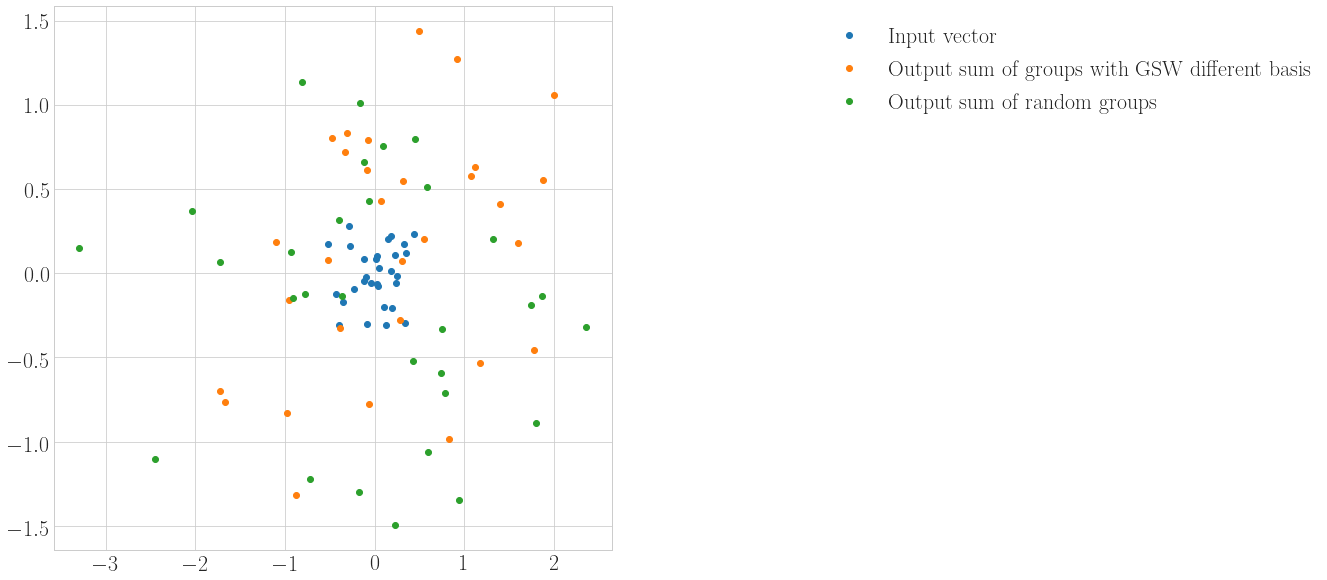

In [31]:
## Trying with a random orthonormal basis (A Gram-Schmidt orthogonalization of a random basis)
n=30
x=np.random.uniform(size=(n,n))
basis=gram_schmidt_columns(x)
v=sample_from_ball(n,d=30)
B=np.transpose(np.vstack(tuple([e for e in v])))
v=np.transpose(np.matmul(np.transpose(np.vstack(tuple([e for e in basis]))),np.vstack(tuple([e for e in v]))))#is v already a list ? If so we can simplify syntax here
v=[v[:,i] for i in range(v.shape[1])]
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),np.ones(n)
gsw_xs=[]
rand_xs=[]
for i in range(n):
    rand_xs.append(2*np.random.randint(2,size=n)-1)
    gsw_xs.append(change_basis(gram_schmidt_walk(v,np.zeros(n),a,b,False,True,False,basis),basis,orthonormal_basis(n)))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW different basis')
plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups')

plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

In [190]:
print(gsw_xs)

[array([-4.985e-01, -1.707e+00, -8.417e-01, 8.880e-01, 5.840e-01]), array([-1.745e-01, 1.609e-01, 1.805e+00, -1.266e+00, -2.894e-01]), array([-7.328e-01, -1.501e+00, -1.566e-01, 7.660e-01, -1.265e+00]), array([-7.328e-01, -1.501e+00, -1.566e-01, 7.660e-01, -1.265e+00]), array([-1.811e-01, 1.639e+00, 9.899e-01, 9.859e-01, -5.743e-01])]


In [10]:
def average(list_):
    return sum(list_)/len(list_)

In [22]:
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=n here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=100
v=sample_from_ball(int(n/2),d=n)
subteam = [0] * int(n-4) + [1/2] * 4
for i in range(int(n/2)):
    random.shuffle(subteam)
    v.append(subteam.copy())
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n/2])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[int(n/2):]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:int(n/2)]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 5.632696869526155
Average time step of coloring of structured elements: 42.38
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #1
Output norm: 5.3448482858229225
Average time step of coloring of structured elements: 48.68
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 4.909550732249168
Average time step of coloring of structured elements: 50.88
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #3
Output norm: 4.9829038071077285
Average time step of coloring of structured elements: 45.92
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:0.0

 Try #4
Output norm: 5.0564546231419945
Average time step of coloring of structured elements: 46.82
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:

Output norm: 5.200401710835154
Average time step of coloring of structured elements: 47.1
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #42
Output norm: 5.137826043989671
Average time step of coloring of structured elements: 45.86
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:0.0

 Try #43
Output norm: 5.195520810818796
Average time step of coloring of structured elements: 44.1
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #44
Output norm: 4.848828486652301
Average time step of coloring of structured elements: 50.52
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:4.0

 Try #45
Output norm: 5.051221761144401
Average time step of coloring of structured elements: 51.16
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0

Output norm: 5.379230101419362
Average time step of coloring of structured elements: 43.06
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:6.0

 Try #83
Output norm: 5.779698557382555
Average time step of coloring of structured elements: 47.04
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:8.0

 Try #84
Output norm: 4.890240313246613
Average time step of coloring of structured elements: 46.68
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #85
Output norm: 5.960054623691782
Average time step of coloring of structured elements: 53.54
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:10.0

 Try #86
Output norm: 5.4959875157610965
Average time step of coloring of structured elements: 41.88
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured poin

In [ ]:
#Try the same with deterministic, with different definittions of structured and n's

In [23]:
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=100
v=sample_from_ball(int(n/2),d=n)
subteam = [0] * int(np.sqrt(n)-4) + [1/2] * 4
for i in range(int(n/2)):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-int(np.sqrt(n)))))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n/2])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[int(n/2):]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:int(n/2)]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 4.873146026211153
Average time step of coloring of structured elements: 45.64
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #1
Output norm: 4.443118719494569
Average time step of coloring of structured elements: 48.72
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:4.0

 Try #2
Output norm: 4.655167943514522
Average time step of coloring of structured elements: 54.94
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:4.0

 Try #3
Output norm: 4.376316105036608
Average time step of coloring of structured elements: 46.2
Coloring discrepancy among structured points:1.1102230246251565e-16
Coloring discrepancy among non-structured points:4.0

 Try #4
Output norm: 5.214539021448999
Average time step of coloring of structured elements: 42.38
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-str

Output norm: 4.785649129078561
Average time step of coloring of structured elements: 49.3
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:4.0

 Try #41
Output norm: 5.014611505336998
Average time step of coloring of structured elements: 48.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #42
Output norm: 4.904999908444628
Average time step of coloring of structured elements: 53.92
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #43
Output norm: 4.67219915924073
Average time step of coloring of structured elements: 41.22
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:6.0

 Try #44
Output norm: 5.407199848227176
Average time step of coloring of structured elements: 45.58
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:8.

Output norm: 5.343720495507724
Average time step of coloring of structured elements: 47.78
Coloring discrepancy among structured points:2.0000000000000004
Coloring discrepancy among non-structured points:0.0

 Try #81
Output norm: 4.561819801445875
Average time step of coloring of structured elements: 48.7
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #82
Output norm: 4.699205824705529
Average time step of coloring of structured elements: 52.26
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #83
Output norm: 4.975307674239176
Average time step of coloring of structured elements: 53.98
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #84
Output norm: 4.613767266171442
Average time step of coloring of structured elements: 55.54
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-str

In [27]:
#Now with deterministic GSW
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
v=sample_from_ball(int(n/2),d=n)
subteam = [0] * int(np.sqrt(n)-4) + [1/2] * 4
for i in range(int(n/2)):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-int(np.sqrt(n)))))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n/2])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[int(n/2):]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:int(n/2)]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.149347349553507
Average time step of coloring of structured elements: 97.69
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:14.0

 Try #1
Output norm: 6.386243920442948
Average time step of coloring of structured elements: 103.76
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #2
Output norm: 6.1620640807079345
Average time step of coloring of structured elements: 94.62
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:34.0

 Try #3
Output norm: 6.2819039633525415
Average time step of coloring of structured elements: 97.93
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:32.0

 Try #4
Output norm: 6.587224805638467
Average time step of coloring of structured elements: 105.59
Coloring discrepancy among structured points:2.220446049250313e-16
Coloring discrepancy among

Output norm: 6.324172220296954
Average time step of coloring of structured elements: 99.98
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:40.0

 Try #41
Output norm: 6.474675960162823
Average time step of coloring of structured elements: 107.57
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:34.0

 Try #42
Output norm: 6.875853079954677
Average time step of coloring of structured elements: 96.13
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:26.0

 Try #43
Output norm: 6.356649597628991
Average time step of coloring of structured elements: 103.17
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #44
Output norm: 6.72394093063865
Average time step of coloring of structured elements: 98.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured po

Output norm: 6.931828129612244
Average time step of coloring of structured elements: 98.91
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #82
Output norm: 6.392665144013921
Average time step of coloring of structured elements: 105.56
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:44.0

 Try #83
Output norm: 6.533454383449715
Average time step of coloring of structured elements: 104.32
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:16.0

 Try #84
Output norm: 6.846959180803074
Average time step of coloring of structured elements: 97.91
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:30.0

 Try #85
Output norm: 6.798829581012907
Average time step of coloring of structured elements: 94.24
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured 

Output norm: 6.726801096499067
Average time step of coloring of structured elements: 102.53
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:24.0

 Try #122
Output norm: 6.585466346849297
Average time step of coloring of structured elements: 108.05
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:32.0

 Try #123
Output norm: 6.1164187868017885
Average time step of coloring of structured elements: 101.18
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:26.0

 Try #124
Output norm: 5.984503604461025
Average time step of coloring of structured elements: 104.34
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #125
Output norm: 6.326905492846523
Average time step of coloring of structured elements: 100.15
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-str

Output norm: 6.4791776743475795
Average time step of coloring of structured elements: 98.15
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:20.0

 Try #162
Output norm: 6.426449728406285
Average time step of coloring of structured elements: 102.46
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:14.0

 Try #163
Output norm: 6.456926004723252
Average time step of coloring of structured elements: 108.26
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #164
Output norm: 6.538438219148269
Average time step of coloring of structured elements: 89.34
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:28.0

 Try #165
Output norm: 6.413120604780446
Average time step of coloring of structured elements: 96.67
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-struct

In [28]:
#Now with deterministic GSW and with much smaller structured group
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-structured)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.326830484088131
Average time step of coloring of structured elements: 48.857142857142854
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:34.0

 Try #1
Output norm: 6.54172525914891
Average time step of coloring of structured elements: 67.57142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #2
Output norm: 6.728668097903917
Average time step of coloring of structured elements: 23.071428571428573
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:30.0

 Try #3
Output norm: 7.402567490976052
Average time step of coloring of structured elements: 49.714285714285715
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:24.0

 Try #4
Output norm: 6.943208868178591
Average time step of coloring of structured elements: 50.57142857142857
Coloring discrepancy among structur

Output norm: 6.980112832515811
Average time step of coloring of structured elements: 53.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:32.0

 Try #40
Output norm: 6.638431042316581
Average time step of coloring of structured elements: 36.142857142857146
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:10.0

 Try #41
Output norm: 6.720196260340057
Average time step of coloring of structured elements: 47.57142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:28.0

 Try #42
Output norm: 6.693462691135282
Average time step of coloring of structured elements: 67.28571428571429
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:40.0

 Try #43
Output norm: 6.540645359589465
Average time step of coloring of structured elements: 46.357142857142854
Coloring discrepancy among structured points

Output norm: 6.890579948482908
Average time step of coloring of structured elements: 37.357142857142854
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:50.0

 Try #79
Output norm: 6.707638292635915
Average time step of coloring of structured elements: 66.78571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #80
Output norm: 6.918770726904829
Average time step of coloring of structured elements: 58.214285714285715
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:48.0

 Try #81
Output norm: 6.7405712410100795
Average time step of coloring of structured elements: 39.142857142857146
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:46.0

 Try #82
Output norm: 6.583682906372139
Average time step of coloring of structured elements: 67.35714285714286
Coloring discrepancy among st

Output norm: 6.72213599511748
Average time step of coloring of structured elements: 44.785714285714285
Coloring discrepancy among structured points:1.1102230246251565e-16
Coloring discrepancy among non-structured points:40.0

 Try #117
Output norm: 6.808129374189569
Average time step of coloring of structured elements: 66.07142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:46.0

 Try #118
Output norm: 6.831246560518086
Average time step of coloring of structured elements: 27.785714285714285
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:18.0

 Try #119
Output norm: 6.956002168156931
Average time step of coloring of structured elements: 69.71428571428571
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:34.0

 Try #120
Output norm: 7.166291707951131
Average time step of coloring of structured elements: 53.57142857142857
Coloring 

Output norm: 6.771172157276082
Average time step of coloring of structured elements: 52.285714285714285
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:16.0

 Try #155
Output norm: 7.028261574852213
Average time step of coloring of structured elements: 47.857142857142854
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:66.0

 Try #156
Output norm: 6.4904994075056885
Average time step of coloring of structured elements: 26.428571428571427
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #157
Output norm: 6.2655570713453725
Average time step of coloring of structured elements: 29.857142857142858
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:38.0

 Try #158
Output norm: 7.123439344883662
Average time step of coloring of structured elements: 47.357142857142854
Coloring discrepancy a

Output norm: 6.584836496838216
Average time step of coloring of structured elements: 55.57142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:34.0

 Try #194
Output norm: 6.748349715739631
Average time step of coloring of structured elements: 41.92857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:28.0

 Try #195
Output norm: 7.082003070173378
Average time step of coloring of structured elements: 42.42857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:40.0

 Try #196
Output norm: 6.847695058477413
Average time step of coloring of structured elements: 42.285714285714285
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:24.0

 Try #197
Output norm: 6.336305782027889
Average time step of coloring of structured elements: 66.92857142857143
Coloring discrepancy among s

In [29]:
#Now with deterministic GSW and with much smaller structured group and n=1000
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=1000
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-structured)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(10):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 15.395904525463505
Average time step of coloring of structured elements: 194.38709677419354
Coloring discrepancy among structured points:3.0
Coloring discrepancy among non-structured points:165.0

 Try #1
Output norm: 15.129006437864984
Average time step of coloring of structured elements: 264.1290322580645
Coloring discrepancy among structured points:1.0
Coloring discrepancy among non-structured points:219.0

 Try #2
Output norm: 15.360975474665619
Average time step of coloring of structured elements: 293.5483870967742
Coloring discrepancy among structured points:5.0
Coloring discrepancy among non-structured points:181.0

 Try #3
Output norm: 16.000697905107604
Average time step of coloring of structured elements: 263.03225806451616
Coloring discrepancy among structured points:3.0
Coloring discrepancy among non-structured points:209.0

 Try #4
Output norm: 15.750435134411715
Average time step of coloring of structured elements: 277.5483870967742
Coloring discrepancy among

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
#The structured points seem to be colored early as well.

In [36]:
#Now with deterministic GSW and with much smaller structured group but with noise in ustructured part
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_from_ball(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))*10/structured),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.965955443157044
Average time step of coloring of structured elements: 65.21428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:42.0

 Try #1
Output norm: 7.119353817212681
Average time step of coloring of structured elements: 100.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #2
Output norm: 6.992110646375976
Average time step of coloring of structured elements: 79.14285714285714
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #3
Output norm: 6.794905086496964
Average time step of coloring of structured elements: 113.85714285714286
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:28.0

 Try #4
Output norm: 7.108132678938077
Average time step of coloring of structured elements: 94.14285714285714
Coloring discrepancy among structured points:0.0

Output norm: 6.501142877600162
Average time step of coloring of structured elements: 107.28571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:40.0

 Try #40
Output norm: 6.532222793859662
Average time step of coloring of structured elements: 64.78571428571429
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:32.0

 Try #41
Output norm: 7.230440094869698
Average time step of coloring of structured elements: 96.64285714285714
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:42.0

 Try #42
Output norm: 6.46328813008919
Average time step of coloring of structured elements: 82.71428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:20.0

 Try #43
Output norm: 6.850840572496975
Average time step of coloring of structured elements: 83.35714285714286
Coloring discrepancy among struct

Output norm: 6.8208029073192105
Average time step of coloring of structured elements: 94.92857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #79
Output norm: 6.651281725981329
Average time step of coloring of structured elements: 72.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:26.0

 Try #80
Output norm: 6.41665365382986
Average time step of coloring of structured elements: 95.07142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:26.0

 Try #81
Output norm: 7.15334598075034
Average time step of coloring of structured elements: 66.14285714285714
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:30.0

 Try #82
Output norm: 6.482354011737262
Average time step of coloring of structured elements: 98.14285714285714
Coloring discrepancy among structured points:0.

In [37]:
#Now with deterministic GSW and with much smaller structured group but with noise in ustructured part that is bigger than before
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_from_ball(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))*100/structured),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.7999931093924175
Average time step of coloring of structured elements: 91.71428571428571
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:44.0

 Try #1
Output norm: 6.645006279734558
Average time step of coloring of structured elements: 84.78571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #2
Output norm: 6.598119724553039
Average time step of coloring of structured elements: 95.85714285714286
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:50.0

 Try #3
Output norm: 6.568192809680166
Average time step of coloring of structured elements: 86.21428571428571
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:42.0

 Try #4
Output norm: 6.535399540347885
Average time step of coloring of structured elements: 78.14285714285714
Coloring discrepancy among structure

Output norm: 7.19515652620214
Average time step of coloring of structured elements: 104.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:26.0

 Try #40
Output norm: 6.640108440889928
Average time step of coloring of structured elements: 103.42857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:38.0

 Try #41
Output norm: 7.019268516694043
Average time step of coloring of structured elements: 79.78571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:52.0

 Try #42
Output norm: 6.908072594839158
Average time step of coloring of structured elements: 104.71428571428571
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:64.0

 Try #43
Output norm: 7.085584408035535
Average time step of coloring of structured elements: 124.42857142857143
Coloring discrepancy among structured point

Output norm: 6.598916143894153
Average time step of coloring of structured elements: 100.64285714285714
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:16.0

 Try #79
Output norm: 7.047223336863335
Average time step of coloring of structured elements: 102.28571428571429
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:34.0

 Try #80
Output norm: 6.906673641203654
Average time step of coloring of structured elements: 114.14285714285714
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:42.0

 Try #81
Output norm: 6.879022812388563
Average time step of coloring of structured elements: 89.0
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:52.0

 Try #82
Output norm: 6.29725948083593
Average time step of coloring of structured elements: 81.5
Coloring discrepancy among structured points:6.0
Coloring

In [38]:
#Now with deterministic GSW and with much smaller structured group but with noise in ustructured part that is even bigger than before
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_from_ball(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))*1000/structured),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.61000599893671
Average time step of coloring of structured elements: 104.14285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:50.0

 Try #1
Output norm: 7.277883098727375
Average time step of coloring of structured elements: 93.78571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:34.0

 Try #2
Output norm: 6.9269403932255225
Average time step of coloring of structured elements: 81.35714285714286
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:20.0

 Try #3
Output norm: 6.209474504800323
Average time step of coloring of structured elements: 91.07142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:48.0

 Try #4
Output norm: 6.670245532702724
Average time step of coloring of structured elements: 110.57142857142857
Coloring discrepancy among structur

Output norm: 6.4963787859709
Average time step of coloring of structured elements: 85.35714285714286
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:46.0

 Try #40
Output norm: 6.563026122077279
Average time step of coloring of structured elements: 94.57142857142857
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:44.0

 Try #41
Output norm: 6.755620699753388
Average time step of coloring of structured elements: 110.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:36.0

 Try #42
Output norm: 7.115623423509565
Average time step of coloring of structured elements: 101.07142857142857
Coloring discrepancy among structured points:8.0
Coloring discrepancy among non-structured points:30.0

 Try #43
Output norm: 6.96103635142451
Average time step of coloring of structured elements: 106.5
Coloring discrepancy among structured points:4.0
Coloring d

Output norm: 6.668480746800915
Average time step of coloring of structured elements: 94.14285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:34.0

 Try #79
Output norm: 6.982386931451039
Average time step of coloring of structured elements: 97.78571428571429
Coloring discrepancy among structured points:8.0
Coloring discrepancy among non-structured points:60.0

 Try #80
Output norm: 6.817823727282866
Average time step of coloring of structured elements: 105.07142857142857
Coloring discrepancy among structured points:8.0
Coloring discrepancy among non-structured points:40.0

 Try #81
Output norm: 6.960051389649485
Average time step of coloring of structured elements: 109.0
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:66.0

 Try #82
Output norm: 6.4749090269977305
Average time step of coloring of structured elements: 69.42857142857143
Coloring discrepancy among structured point

In [63]:
#Now with deterministic GSW and with much smaller structured group but with 0-1 vectors
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_binary(n-structured,d=n)
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 50.950956811427986
Average time step of coloring of structured elements: 75.92857142857143
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:6.0

 Try #1
Output norm: 53.47896782848375
Average time step of coloring of structured elements: 110.28571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:6.0

 Try #2
Output norm: 49.79959839195493
Average time step of coloring of structured elements: 93.57142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 52.64978632435273
Average time step of coloring of structured elements: 84.35714285714286
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #4
Output norm: 50.872389367907616
Average time step of coloring of structured elements: 82.57142857142857
Coloring discrepancy among structured 

Output norm: 55.09990925582364
Average time step of coloring of structured elements: 93.14285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:1.1102230246251565e-16

 Try #40
Output norm: 50.950956811427986
Average time step of coloring of structured elements: 84.35714285714286
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #41
Output norm: 49.91993589739474
Average time step of coloring of structured elements: 72.57142857142857
Coloring discrepancy among structured points:10.0
Coloring discrepancy among non-structured points:8.0

 Try #42
Output norm: 47.32863826479693
Average time step of coloring of structured elements: 74.07142857142857
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #43
Output norm: 51.65268628057983
Average time step of coloring of structured elements: 97.85714285714286
Coloring discrep

Output norm: 50.75431016179808
Average time step of coloring of structured elements: 91.71428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #79
Output norm: 51.146847410177685
Average time step of coloring of structured elements: 98.07142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #80
Output norm: 50.35871324805669
Average time step of coloring of structured elements: 70.57142857142857
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #81
Output norm: 54.4426303552648
Average time step of coloring of structured elements: 86.14285714285714
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #82
Output norm: 51.10772935672255
Average time step of coloring of structured elements: 89.64285714285714
Coloring discrepancy among structured

In [64]:
#Now with deterministic GSW and with n/2 structured group but with 0-1 vectors
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(n/2)
v=sample_binary(n-structured,d=n)
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 46.87216658103186
Average time step of coloring of structured elements: 73.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #1
Output norm: 42.906875905849866
Average time step of coloring of structured elements: 78.83
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 47.54997371187496
Average time step of coloring of structured elements: 82.1
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 50.882216932834204
Average time step of coloring of structured elements: 73.92
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #4
Output norm: 45.35416188179427
Average time step of coloring of structured elements: 79.58
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

Output norm: 45.880278987817846
Average time step of coloring of structured elements: 82.86
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #42
Output norm: 49.84977432245807
Average time step of coloring of structured elements: 76.32
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #43
Output norm: 44.82186966202994
Average time step of coloring of structured elements: 80.87
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #44
Output norm: 43.60045871318328
Average time step of coloring of structured elements: 82.22
Coloring discrepancy among structured points:1.1102230246251565e-16
Coloring discrepancy among non-structured points:0.0

 Try #45
Output norm: 47.042533945356304
Average time step of coloring of structured elements: 80.31
Coloring discrepancy among structured points:4.0
Coloring discrepancy among 

Output norm: 46.52956049652737
Average time step of coloring of structured elements: 78.08
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:0.0

 Try #83
Output norm: 45.13313638558703
Average time step of coloring of structured elements: 85.43
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:0.0

 Try #84
Output norm: 46.184412955021955
Average time step of coloring of structured elements: 78.62
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #85
Output norm: 47.25462940284264
Average time step of coloring of structured elements: 75.46
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #86
Output norm: 42.485291572496
Average time step of coloring of structured elements: 76.51
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:

In [65]:
#Now with deterministic GSW and with much smaller structured group but with 0-1 vectors that are normalized
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_binary(n-structured,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 5.259577841388541
Average time step of coloring of structured elements: 86.0
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #1
Output norm: 5.119221396352396
Average time step of coloring of structured elements: 83.21428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 5.050642883576685
Average time step of coloring of structured elements: 103.57142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 5.138960538726464
Average time step of coloring of structured elements: 99.28571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #4
Output norm: 4.897005150293429
Average time step of coloring of structured elements: 89.71428571428571
Coloring discrepancy among structured points:2.0
Colo

Output norm: 5.218453804165391
Average time step of coloring of structured elements: 76.92857142857143
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #40
Output norm: 5.072317245824143
Average time step of coloring of structured elements: 104.64285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #41
Output norm: 5.243979671782766
Average time step of coloring of structured elements: 77.21428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #42
Output norm: 4.908294606125224
Average time step of coloring of structured elements: 108.64285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:6.0

 Try #43
Output norm: 5.1434188627392885
Average time step of coloring of structured elements: 83.14285714285714
Coloring discrepancy among structu

Output norm: 4.712807675859024
Average time step of coloring of structured elements: 75.28571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #79
Output norm: 4.8342802994400484
Average time step of coloring of structured elements: 99.92857142857143
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:6.0

 Try #80
Output norm: 5.0832150237150495
Average time step of coloring of structured elements: 96.35714285714286
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #81
Output norm: 4.825756554093671
Average time step of coloring of structured elements: 104.21428571428571
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #82
Output norm: 5.258256841904287
Average time step of coloring of structured elements: 94.85714285714286
Coloring discrepancy among structu

In [66]:
#Now with deterministic GSW and with much n/2 structured group but with 0-1 vectors that are normalized
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(n/2)
v=sample_binary(n-structured,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 5.405906873638027
Average time step of coloring of structured elements: 101.37
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #1
Output norm: 4.79875515553884
Average time step of coloring of structured elements: 101.3
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 4.812712466621918
Average time step of coloring of structured elements: 91.71
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 5.087872834601378
Average time step of coloring of structured elements: 93.97
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #4
Output norm: 5.2061945653432495
Average time step of coloring of structured elements: 97.41
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.

Output norm: 5.256488086766064
Average time step of coloring of structured elements: 97.45
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #42
Output norm: 5.374313421219345
Average time step of coloring of structured elements: 87.93
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #43
Output norm: 5.1867257841464
Average time step of coloring of structured elements: 97.07
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #44
Output norm: 5.200574965248875
Average time step of coloring of structured elements: 94.38
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #45
Output norm: 4.835438086596511
Average time step of coloring of structured elements: 84.18
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0

Output norm: 4.97545542216702
Average time step of coloring of structured elements: 90.1
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #83
Output norm: 5.238800727541338
Average time step of coloring of structured elements: 89.87
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #84
Output norm: 4.722296370257203
Average time step of coloring of structured elements: 86.82
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #85
Output norm: 5.032429359525367
Average time step of coloring of structured elements: 83.91
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #86
Output norm: 5.247019352099304
Average time step of coloring of structured elements: 84.44
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2

In [ ]:
#Try with 0 and 1's only vector normalized or not, try to put random stuff on the 0 part of the non-structured vectors
# Try with noise over everythng, or just the structured or unstructured part.
#Try to choose pivot based on which pivot increases disc the least

v:[array([1.015e-01, -5.445e-01]), array([8.514e-02, 5.259e-01]), array([-1.143e-01, 4.897e-01])]
xs: [array([1.000e+00, 1.232e-01, 9.796e-01]), array([-1.000e+00, -1.232e-01, -9.796e-01])]
sum:[array([1.804e-16, 3.331e-16]), array([-1.804e-16, -3.331e-16])]


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


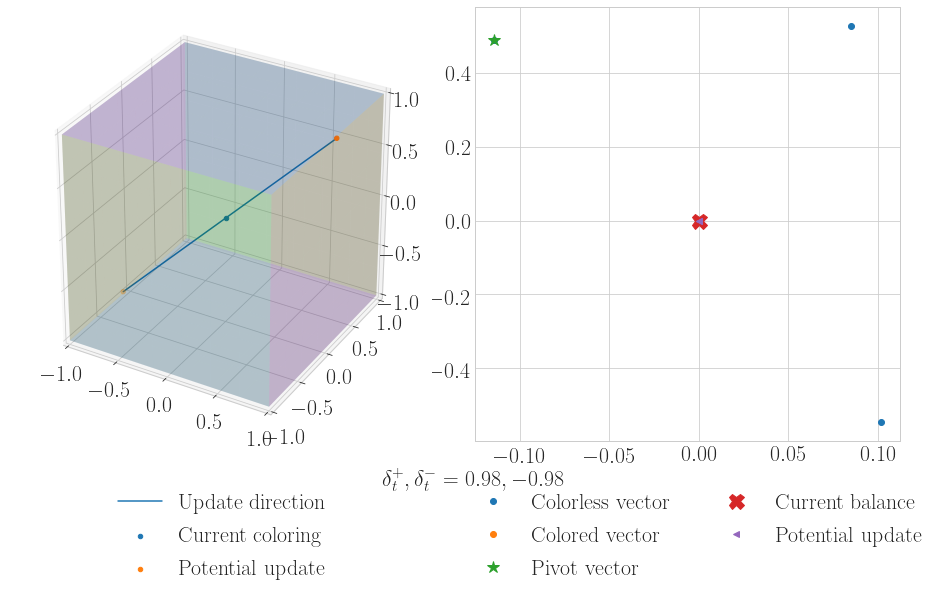

xs: [array([1.000e+00, 1.054e-01, 1.000e+00]), array([1.000e+00, 1.000e+00, -2.457e-02])]
sum:[array([-3.849e-03, 6.231e-04]), array([1.894e-01, -3.067e-02])]


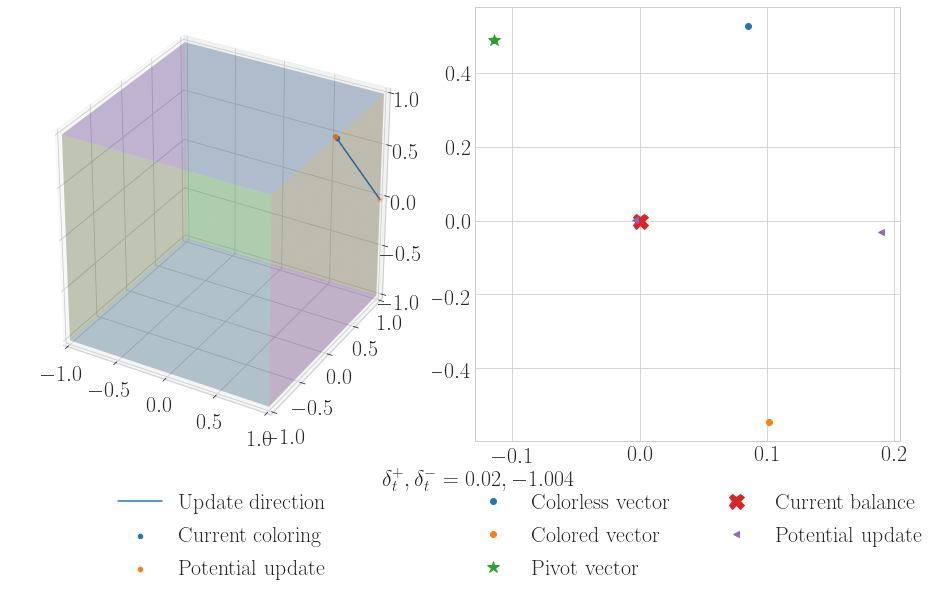

xs: [array([1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([-9.796e-02, -5.807e-01]), array([7.232e-02, 4.711e-01])]


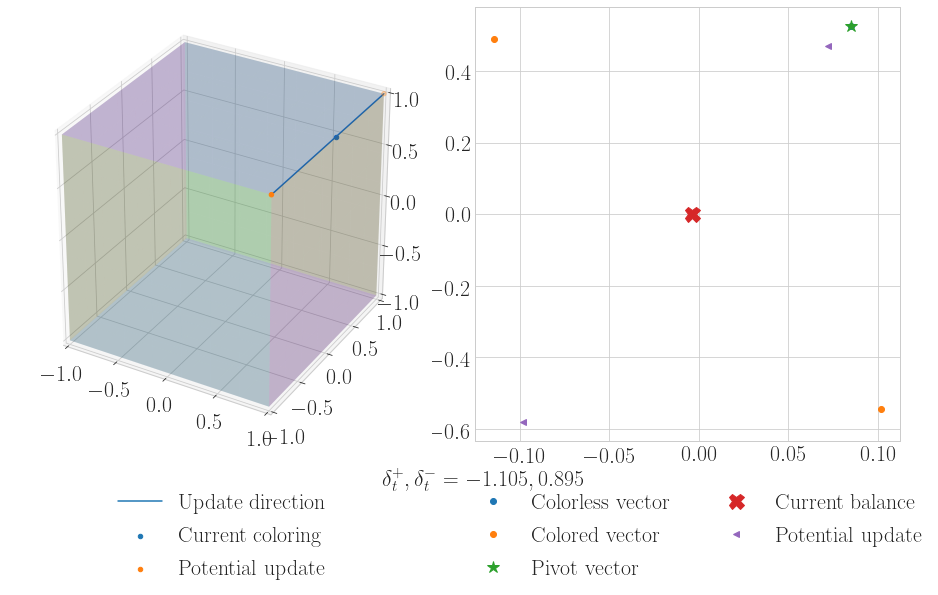

In [34]:
n=3
v=sample_from_sphere(n)
v=sample_from_ball(n)
print(f'v:{v}')
xs=[]
x=gram_schmidt_walk(v,np.zeros(n),plot=True)

n=10
2


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


8
32
128
512


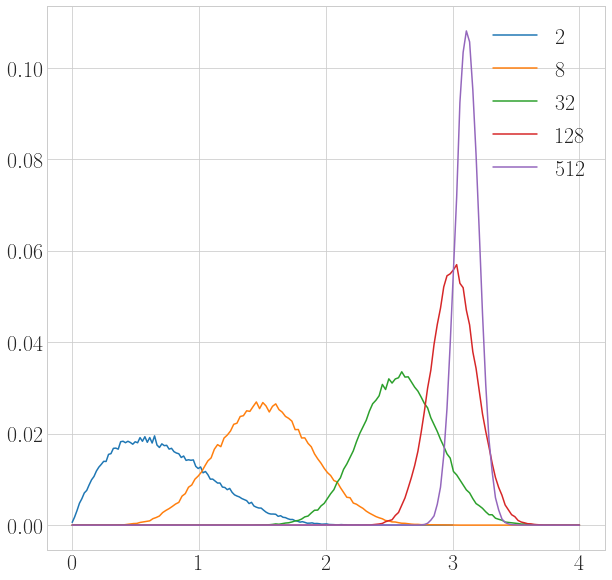

n=20
2
8
32
128
512


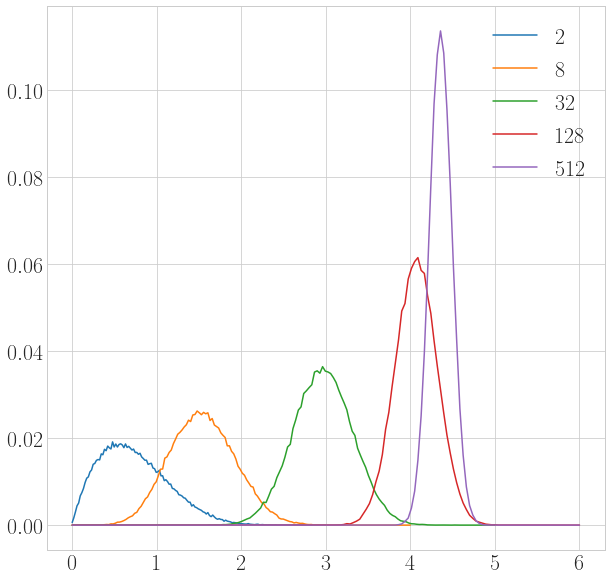

n=40
2
8
32
128
512


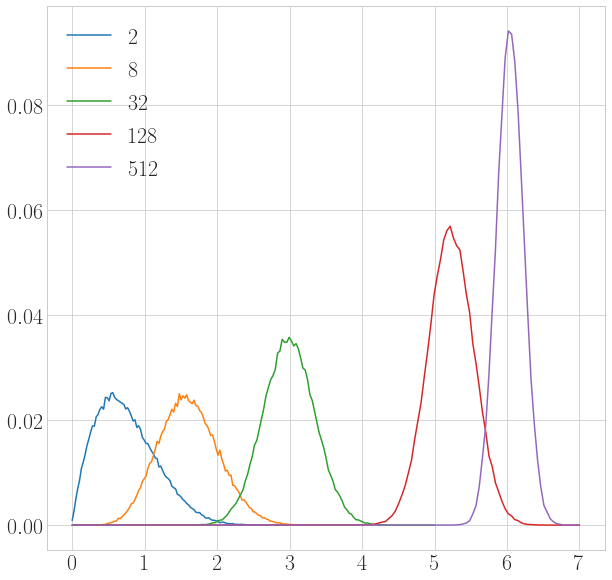

In [6]:
#maybe multiplot with different n ?
l=[2,8,32,128,512]
n_list=[10,20,40]
repeat=10**5
norms={}
for n in n_list:
    print(f'n={n}')
    norms[n]={}
    for d in l:
        print(d)
        norms[n][d]=[]
        for i in range(repeat):
            v=sample_from_ball(n,d=d)
            x=gram_schmidt_walk(v,np.zeros(n))
            B=np.transpose(np.vstack(tuple([e for e in v])))
            norms[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x)])))
        h=int(np.ceil(max(norms[n][d])))
        split=int(np.sqrt(repeat)/2)
        r=np.linspace(0,h,split)
        num=[sum(map(lambda x:int((norm<=x) and (x<(norm+h/split))),norms[n][d]))/repeat for norm in r]
        plt.plot(r,num,label=str(d))
    plt.legend()
    plt.savefig(f'norms{n}.pdf')
    tikzplotlib.save(f"norms_n{n}.tex")
    plt.show()

n=5
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536


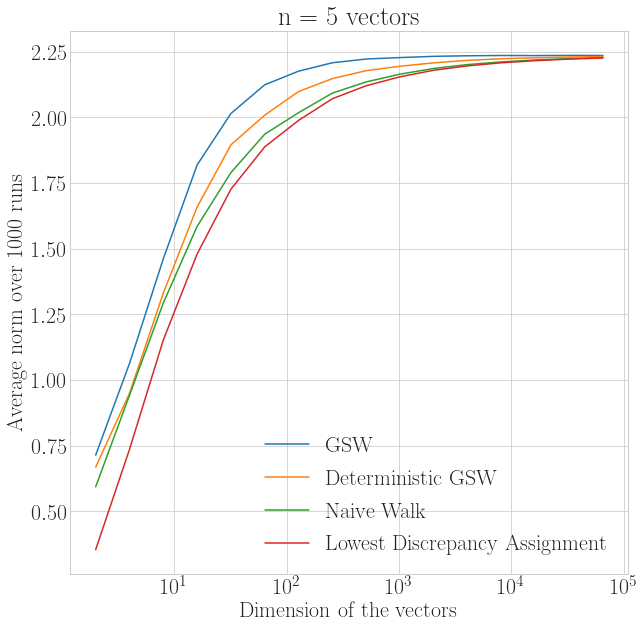

n=10
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536


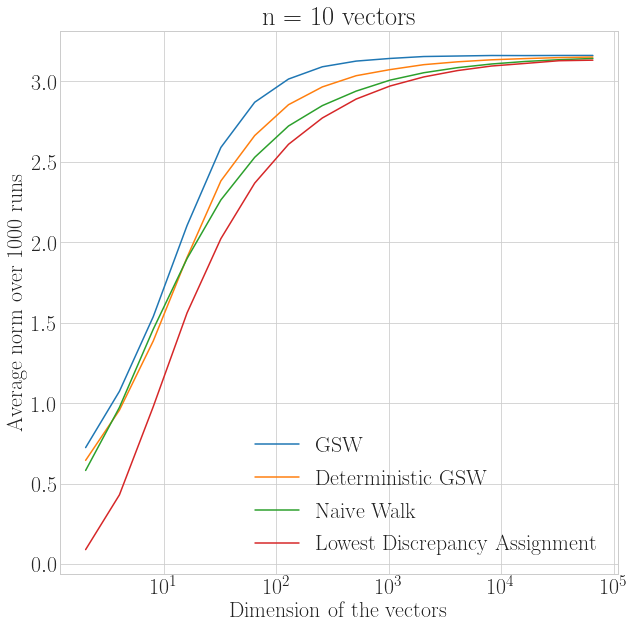

n=15
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:186: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


65536


KeyboardInterrupt: 

In [20]:
max_power=16.0
l=np.logspace(1.0, max_power, num=int(max_power), base=2.0)
n_list=[5,10,15,20,40]
#n_list=[5,10]
repeat=10**3
#repeat=10**1

#load dics
norms_gsw=open_dic_file('norms_gsw.pkl')
norms_gsw_det=open_dic_file('norms_gsw_det.pkl')
norms_naive=open_dic_file('norms_naive.pkl')
norms_best=open_dic_file('norms_best.pkl')

for n in n_list:
    print(f'n={n}')
    if norms_gsw.get(n) is None:
        norms_gsw[n]={}
    if norms_gsw_det.get(n) is None:
        norms_gsw_det[n]={}
    if norms_naive.get(n) is None:
        norms_naive[n]={}
    if norms_best.get(n) is None:
        norms_best[n]={}
    for d_ in l:
        d=int(d_)
        print(d)
        if norms_gsw[n].get(d) is None:
            norms_gsw[n][d]=[]
        if norms_gsw_det[n].get(d) is None:
            norms_gsw_det[n][d]=[]
        if norms_naive[n].get(d) is None:
            norms_naive[n][d]=[]
        if norms_best[n].get(d) is None:
            norms_best[n][d]=[]
        while len(norms_gsw[n][d])<repeat:
            v=sample_from_ball(n,d=d)
            x=gram_schmidt_walk(v,np.zeros(n))
            B=np.transpose(np.vstack(tuple([e for e in v])))
            norms_gsw[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x)])))
            x_det=gram_schmidt_walk(v,np.zeros(n),smallest_delta=True)
            norms_gsw_det[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x_det)])))
            x_naive=naive_walk(v)
            norms_naive[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x_naive)])))
            if n<=10:
                disc,x_best=best_coloring(v)
                norms_best[n][d].append(disc)
    plt.plot(l,[sum(norms_gsw[n][d])/repeat for d in l],label=f'GSW')
    plt.plot(l,[sum(norms_gsw_det[n][d])/repeat for d in l],label=f'Deterministic GSW')
    plt.plot(l,[sum(norms_naive[n][d])/repeat for d in l],label=f'Naive Walk')
    plt.plot(l,[sum(norms_best[n][d])/repeat for d in l],label=f'Lowest Discrepancy Assignment')
    plt.title(f'n = {n} vectors')
    plt.xlabel('Dimension of the vectors')
    plt.ylabel(f'Average norm over {repeat} runs')
    plt.legend()
    plt.xscale('log')
    plt.savefig(f'comparative_norms_n={n}_repeat={repeat}_max_dim={2**max_power}.pdf')
    tikzplotlib.save(f"comparative_norms_n={n}_repeat={repeat}_max_dim={2**max_power}.tex")
    plt.show()

In [21]:
#save dics
save_dic_to_file(norms_gsw,'norms_gsw.pkl')
save_dic_to_file(norms_gsw_det,'norms_gsw_det.pkl')
save_dic_to_file(norms_naive,'norms_naive.pkl')
save_dic_to_file(norms_best,'norms_best.pkl')

In [259]:
X=np.array([[0,0,1],[0,1,0],[2,1,1]])
print(X)
print(gram_schmidt_columns(X))

[[0 0 1]
 [0 1 0]
 [2 1 1]]
[[0.000e+00 0.000e+00 -1.000e+00]
 [-0.000e+00 1.000e+00 0.000e+00]
 [-1.000e+00 -0.000e+00 0.000e+00]]


In [320]:
n=10
x=np.random.uniform(size=(n,n))
basis=gram_schmidt_columns(x)
v=sample_from_ball(n)
print(v)
v=np.transpose(np.matmul(np.transpose(np.vstack(tuple([e for e in basis]))),np.vstack(tuple([e for e in v]))))#is v already a list ? If so we can simplify syntax here
v=[v[:,i] for i in range(v.shape[1])]
print(v)

[array([-2.574e-01, 7.914e-01]), array([7.866e-01, 4.301e-01]), array([-3.746e-01, -6.659e-01]), array([6.826e-01, 4.059e-01]), array([5.890e-02, -3.040e-01]), array([6.808e-01, 1.020e-02]), array([7.960e-01, 1.972e-02]), array([7.478e-01, -3.739e-01]), array([-8.899e-01, 8.589e-02]), array([4.134e-01, 4.869e-01])]
[array([-8.283e-01, 3.123e-03]), array([-3.716e-01, 3.267e-01]), array([2.925e-01, 4.570e-01]), array([3.139e-01, 7.879e-01]), array([8.818e-01, 6.184e-01]), array([2.303e-01, 3.884e-02]), array([2.398e-01, 4.689e-01]), array([-1.207e+00, 4.780e-01]), array([7.476e-01, 2.336e-01]), array([3.783e-02, -2.712e-01])]


In [9]:
l=[1,2,3]
print(l[0:2])

[1, 2]


In [30]:
print(inv(np.array([[2,3,1],[1,1,0],[1,4,-1]])))
print(inv(np.array([[2,0,3,1],[1,0,1,0],[0,0,0,0],[1,0,4,-1]])))

[[-2.500e-01 1.750e+00 -2.500e-01]
 [2.500e-01 -7.500e-01 2.500e-01]
 [7.500e-01 -1.250e+00 -2.500e-01]]
[[-2.500e-01 1.750e+00 0.000e+00 -2.500e-01]
 [-3.331e-16 4.441e-16 0.000e+00 8.327e-17]
 [2.500e-01 -7.500e-01 0.000e+00 2.500e-01]
 [7.500e-01 -1.250e+00 0.000e+00 -2.500e-01]]


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [57]:
l=np.array([1,2,3])
new=np.append(l,4)
print(new)

[1 2 3 4]


In [185]:
b1=[np.array([1,2]),np.array([0,1])]
b2=orthonormal_basis(2)
print(change_basis(np.array([1,1]),b1,b2))

[1.000e+00 3.000e+00]


In [90]:
v=[np.array([1.0,0.,1.]),np.array([2.,0.,1.]),np.array([0.,0.,1.]),np.array([3.,0.,4.])]
q,r=np.linalg.qr(np.transpose(np.vstack(tuple([e for e in v]))))
v_p=np.array([1,2,1])
rs=np.array([(r[i,:]==np.zeros(r.shape[1])).all() for i in range(r.shape[0])])
print(rs)
q=q[:,~rs]
v_perp=v_p-q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T).dot(v_p)
print(q)
print(r)
print(v_perp)

[False False  True]
[[-7.071e-01 -7.071e-01]
 [-0.000e+00 0.000e+00]
 [-7.071e-01 7.071e-01]]
[[-1.414e+00 -2.121e+00 -7.071e-01 -4.950e+00]
 [0.000e+00 -7.071e-01 7.071e-01 7.071e-01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]]
[0.000e+00 2.000e+00 0.000e+00]


In [68]:
print(np.transpose(np.vstack(tuple([e for e in v]))))

[[1 2 0 3]
 [0 0 0 0]
 [1 1 1 4]]


In [74]:
#q=np.transpose(np.vstack(tuple([e for e in v])))
q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T)

array([[1.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00]])

In [71]:
print(r)

[[-1.414e+00 -2.121e+00 -7.071e-01 -4.950e+00]
 [0.000e+00 -7.071e-01 7.071e-01 7.071e-01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]]


In [73]:
!pip install numpy --upgrade

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'C:\\Users\\GABO~1\\AppData\\Local\\Temp\\pip-uninstall-1__xnp5g\\core\\_multiarray_tests.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [78]:
q.dot(r)

array([[1.000e+00, 2.000e+00, -1.110e-16, 3.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00]])

In [9]:
v=[np.array([1,1,1]),np.array([1,0,0]),np.array([0,1,0]),np.array([2,1,0])]
basis=[np.array([1,0,0,0]),np.array([0,0,1,0]),np.array([0,1,0,0]),np.array([0,0,4,1])]
B=np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis])).T)
print(B)

[[1 0 1 2]
 [1 1 0 5]
 [1 0 0 0]]
